<h1 style='color:orange; font-weight:bold; text-align:center'> Time Series Forecasting of Air Pollutant in Jakarta</h1>

## **1 Scenario**
While ozone in statosphere protects us from harmful utraviolet radiation from the sun by absobing some portion of the light, the ground-level ozone is not safe for human respiratory health. Exposure to ground-level ozone are associated with irritation in respiratory system for short-term and even lung cancer for long-term period ([Filippidou & Koukouliata, 2011]([umb.edu.pl/photo/pliki/progress-file/phs/phs_2011_2/144-155.pdf](https://www.umb.edu.pl/photo/pliki/progress-file/phs/phs_2011_2/144-155.pdf))). For this reason, understanding the fluctuation of ozone concentration in the ground level is crucial for individuals to maintain their respiratory health. Understanding and forecasting the fluctuation is also critical for designing environmental policies, including by Environmental Management Agency. This information helps the agency predict the pollutant spike and assist in providing health advisories.

In relation to this issue, this project aims to understand the long-term trend in ground-level ozone (O<sub>3</sub>) concentration. <span style='color:red'>Jelaskan kenapa fokus ke ozone</span>. Accurate predictions are required to forecast the concentration of the air pollutant for data-driven policy-making, and the central issue in the model building is how accurate time series models, e.g., ARIMA, SARIMA, Prophet, and RNN variants, forecast trend in air pollution.

To evaluate the time series model for forecasting ozone concentrations, RMSE will be utilized. RMSE focuses on large errors by penalizing them more heavily. Penalization of large deviations is required since the deviations represent critical health risk. In addition to the focus of RMSE on penalizing large deviations, RMSE is also more considered than, for example, MSE. Unlike MSE, RMSE uses the same scale as the variable of interest (ozone concentration in ppm), making the output easier to understand. For example, RMSE 10 directly represents on average the model's predictions are off by 10 ppm.

Dataset to build the time series models was obtained from [Pohan](https://www.kaggle.com/datasets/senadu34/air-quality-index-in-jakarta-2010-2021) on Kaggle. This dataset contains 11 columns, including date ranging between 2010 and 2023.
- `tanggal`: Date of the air quality index was recorded.
- `stasiun`: Monitoring station name
- `pm10`: Concentration of particular matter (PM) with a diameter of 10 micrometers or less ($\mu \text{g}/\text{m}^3$)
- `pm25`: Concentration of PM with a diameter of 2.5 micrometer or less (also referred as "fine particular matter", measured in $\mu \text{g}/\text{m}^3$)
- `so2`: Concentration of sulfur dioxide (parts per million, ppm)
- `co`: Concentration of carbon monoxide (parts per million, ppm)
- `o3`: Concentration of ozone (parts per million, ppm)
- `no2`: Concentration of nitrogen dioxide (parts per million, ppm)
- `max`: Max value recorded among pollutants for specific entry.
- `critical`: Pollutant with the highest concentration
- `category`: Air quality category based on column max.

## **2 Initial Inspection and Exploration**

In [686]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('ggplot')
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import shapiro
from scipy.stats import skew, kurtosis
from scipy.stats import mstats
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from prophet.plot import plot_components_plotly
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

### **2.1 Basic Inspection**

In [687]:
# import dataframe
df = pd.read_csv('../data/ispu_dki_all.csv')

In [688]:
# create function to inspect df
def inspect_dataframe(df):
    summary = {
        'ColumnName': df.columns.values.tolist(),
        'Nrow': df.shape[0],
        'DataType': df.dtypes.values.tolist(),
        'NAPct': (df.isna().mean() * 100).round(2).tolist(),
        'DuplicatePct': (df.duplicated().sum()/len(df)*100).round(2),
        'UniqueValue': df.nunique().tolist(),
        'Sample': [df[col].unique() for col in df.columns]
    }
    return pd.DataFrame(summary)

In [689]:
# inspect dataframe
print(f'The dataframe contains {df.shape[0]} rows and {df.shape[1]} cols.')
print(f"- {len(df.select_dtypes(include='number').columns)} are numeric cols")
print(f"- {len(df.select_dtypes(include='O').columns)} are object cols")
inspect_dataframe(df)

The dataframe contains 4626 rows and 11 cols.
- 7 are numeric cols
- 4 are object cols


ColumnName  Nrow DataType  NAPct  DuplicatePct  UniqueValue  \
0     tanggal  4626   object   0.00           0.0         4626   
1     stasiun  4626   object   0.00           0.0            5   
2        pm10  4626  float64   3.46           0.0          131   
3        pm25  4626  float64  84.37           0.0          123   
4         so2  4626  float64   0.41           0.0           87   
5          co  4626  float64   0.17           0.0           94   
6          o3  4626  float64   0.11           0.0          264   
7         no2  4626  float64   0.17           0.0           75   
8         max  4626  float64   0.00           0.0          244   
9    critical  4626   object   0.02           0.0            6   
10   categori  4626   object   0.00           0.0            6   

                                               Sample  
0   [2010-01-01, 2010-01-02, 2010-01-03, 2010-01-0...  
1   [DKI1 (Bunderan HI), DKI2 (Kelapa Gading), DKI...  
2   [60.0, 32.0, 27.0, 22.0, 25.0, 30.0, 41.0, 64....  
3   [nan, 60.0, 126.0, 70.0, 53.0, 59.0, 51.0, 55....  
4   [4.0, 2.0, 3.0, 8.0, 5.0, 10.0, 6.0, 7.0, 9.0,...  
5   [73.0, 16.0, 19.0, 17.0, 22.0, 24.0, 51.0, 39....  
6   [27.0, 33.0, 20.0, 15.0, 19.0, 23.0, 26.0, 9.0...  
7   [14.0, 9.0, 6.0, 8.0, 11.0, 13.0, 15.0, 16.0, ...  
8   [73.0, 33.0, 27.0, 22.0, 25.0, 30.0, 41.0, 64....  
9                 [CO, O3, PM10, NO2, SO2, PM25, nan]  
10  [SEDANG, BAIK, TIDAK SEHAT, SANGAT TIDAK SEHAT...

**Note**: <span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [690]:
# convert to datetime
df['tanggal'] = pd.to_datetime(df['tanggal'], format='%Y-%m-%d')
df['tanggal'].dtype

dtype('<M8[ns]')

### **2.2 Feature Selection**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [691]:
# prepare data
critical_df = df['critical'].value_counts().reset_index(name='count')
critical_unhealthy_df = (df[df['categori'] == 'SANGAT TIDAK SEHAT']['critical']
                         .value_counts().reset_index(name='count'))

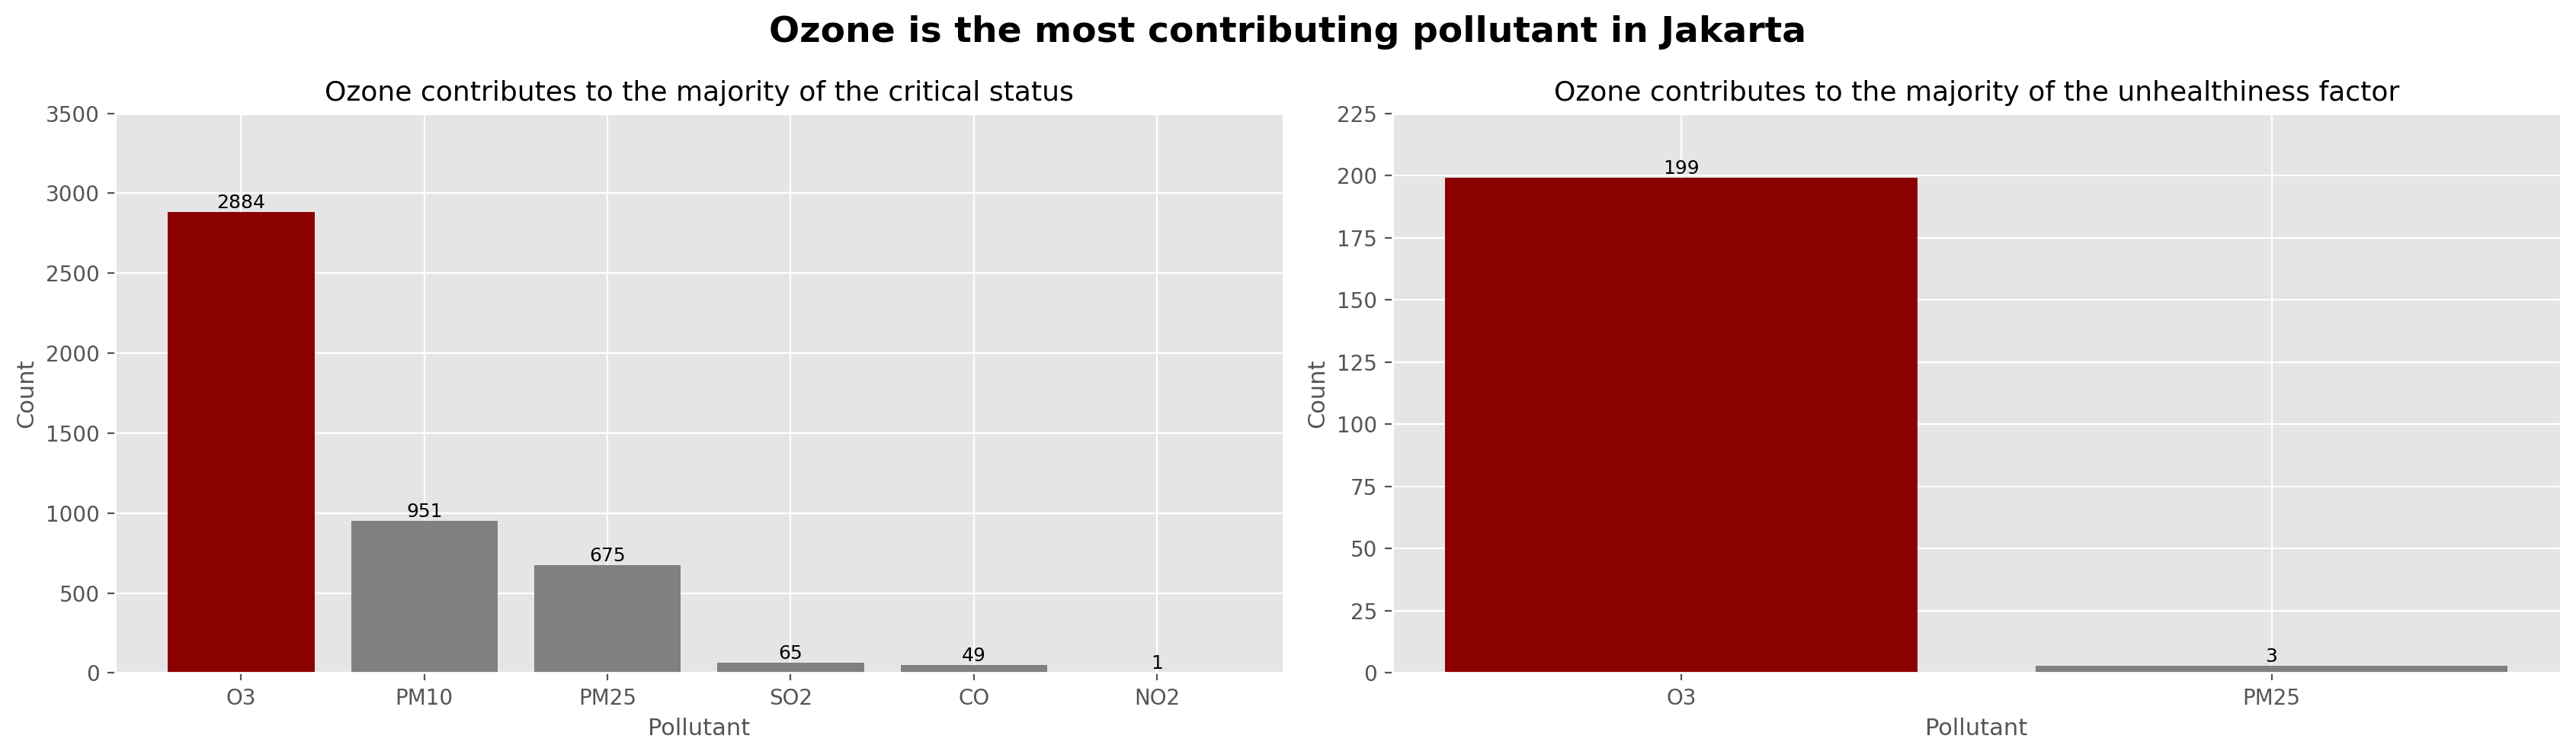

In [692]:
# create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 5), dpi=200)

# plot 1: critical factor
bars = (axes[0].bar(critical_df['index'], critical_df['count'], 
                    color=['darkred' if pollutant == 'O3' else 'grey' 
                           for pollutant in critical_df['index']]))

# add labels to plot 1
for bar in bars:
    yval = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', size=9)

axes[0].set_xlabel('Pollutant', size=11)
axes[0].set_ylabel('Count', size=11)
axes[0].set_title('Ozone contributes to the majority of the critical status', size=13)
axes[0].set_ylim(0, 3500)
axes[0].set_xticks(range(len(critical_df['index'])))
axes[0].set_xticklabels(critical_df['index'], rotation=0)

# plot 2: unhealthiness factor
bars = (axes[1].bar(critical_unhealthy_df['index'], critical_unhealthy_df['count'], 
                    color=['darkred' if pollutant == 'O3' else 'grey' 
                           for pollutant in critical_unhealthy_df['index']]))

# add labels to plot 2
for bar in bars:
    yval = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom', size=9)

axes[1].set_xlabel('Pollutant', size=11)
axes[1].set_ylabel('Count', size=11)
axes[1].set_title('Ozone contributes to the majority of the unhealthiness factor', size=13)
axes[1].set_ylim(0, 225)
axes[1].set_xticks(range(len(critical_unhealthy_df['index'])))
axes[1].set_xticklabels(critical_unhealthy_df['index'], rotation=0)

plt.suptitle('Ozone is the most contributing pollutant in Jakarta', size=17, fontweight='bold')
plt.tight_layout()
plt.show()

**Note**: <span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [693]:
# select col and reinspect df
df = df.loc[:, ['tanggal', 'o3']]
inspect_dataframe(df)

ColumnName  Nrow        DataType  NAPct  DuplicatePct  UniqueValue  \
0    tanggal  4626  datetime64[ns]   0.00           0.0         4626   
1         o3  4626         float64   0.11           0.0          264   

                                              Sample  
0  [2010-01-01T00:00:00.000000000, 2010-01-02T00:...  
1  [27.0, 33.0, 20.0, 15.0, 19.0, 23.0, 26.0, 9.0...

### **2.3 Handle Missing Values**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [694]:
# impute data with interpolation
df['o3_int'] = df['o3'].interpolate(method='linear')

# compare distribution
df[['o3', 'o3_int']].describe().transpose().round(2)

count   mean    std  min   25%   50%    75%    max
o3      4621.0  86.59  50.30  0.0  51.0  78.0  110.0  314.0
o3_int  4626.0  86.51  50.32  0.0  51.0  78.0  110.0  314.0

**Note**: <span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [695]:
# rename o3_int to o3
df.drop(columns='o3', inplace=True)
df.rename(columns={'o3_int':'o3'}, inplace=True)
df.head()

tanggal    o3
0 2010-01-01  27.0
1 2010-01-02  33.0
2 2010-01-03  20.0
3 2010-01-04  15.0
4 2010-01-05  15.0

### **2.4 Check Distribution of Ozone Concentration**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

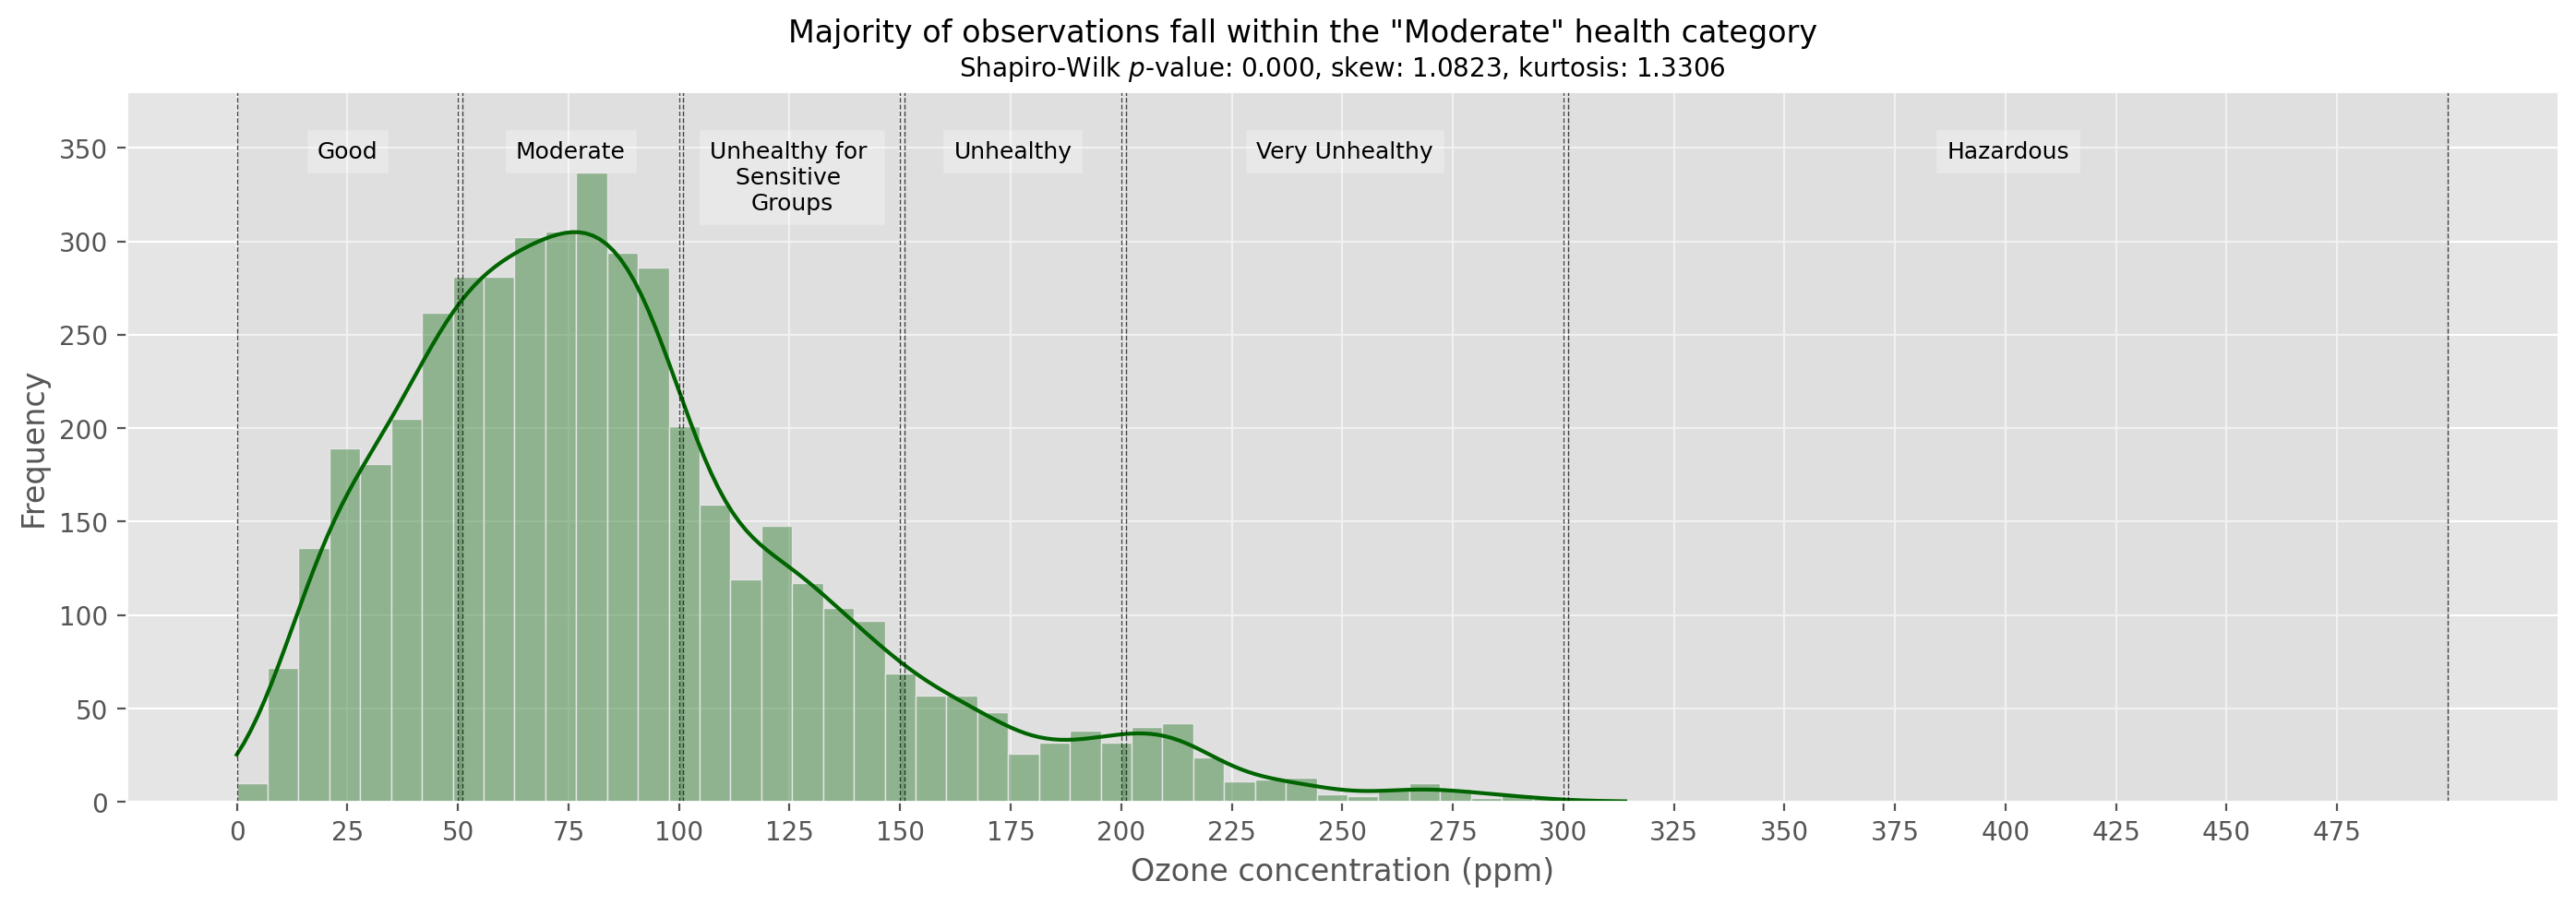

In [696]:
# define concentration & health impact categories
categories = {
    'Good': (0, 50),
    'Moderate': (51, 100),
    'Unhealthy for \nSensitive \nGroups': (101, 150),
    'Unhealthy': (151, 200),
    'Very Unhealthy': (201, 300),
    'Hazardous': (301, 500)
}

# calculate statistical measures
kurt_value = kurtosis(df['o3'])
skw_value = skew(df['o3'])
stat, p_value = shapiro(df['o3'])

# plot histogram and KDE
plt.figure(figsize=(17, 5), dpi=200)
sns.histplot(x=df['o3'], kde=True, color='darkgreen')

# annotate categories with vertical lines and shaded areas
for i, (label, (low, high)) in enumerate(categories.items()):
    plt.axvline(x=low, color='black', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.axvline(x=high, color='black', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.axvspan(low, high, color='lightgray', alpha=0.3)
    plt.text((low + high) / 2, plt.ylim()[1] * 1, label,
             horizontalalignment='center', verticalalignment='top',
             fontsize=9, color='black', bbox=dict(facecolor='white', alpha=0.3))

# add title and labels
plt.title(f'Shapiro-Wilk $p$-value: {p_value:.3f}, skew: {skw_value:.4f}, kurtosis: {kurt_value:.4f}', 
          size=10, color='black')
plt.suptitle('Majority of observations fall within the "Moderate" health category', y=0.96)
plt.xlabel('Ozone concentration (ppm)')
plt.ylabel('Frequency')
plt.xticks(range(0, 500, 25))
plt.ylim(0, 380)
plt.show()


In [697]:
# compute descriptive statistics
df['o3'].describe().to_frame().transpose().round(2)

count   mean    std  min   25%   50%    75%    max
o3  4626.0  86.51  50.32  0.0  51.0  78.0  110.0  314.0

**Note**
- In general, the distribution of the ozone concentration in Jakarta is not normal as indicated by the p-value of Shapiro-Wilk test lower than 0.05. The skewness value here represents the shape of the distribution which is positively skewed due to the presence of outliers in the right-end of the distribution. In addition to the p-value and the skewness, the kurtosis value suggests that the distribution has heavy tail (leptokurtic). Leptokurtic distribution also underscores the presence of outliers. Ideally, the desirable kurtosis value is 0, indicating mesokurtic or normal distribution.
- The central tendency of the ozone concentration falls within moderate health category. As can be seen on the descriptive statistical test output, despite discrepancy between mean and median values due to the skewed distribution, both median and mean remain falling within "moderate" category. This tenency indicates that overall, the ozone concentration in Jakarta is still normal or healthy for the majority of people.
- Some observations, especially the extreme cases, fall within the hazardous category. This signifies that in rare cases, the ozone concentration in the capital city can be hazardous to people's health. 

### **2.5 Check Outliers**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

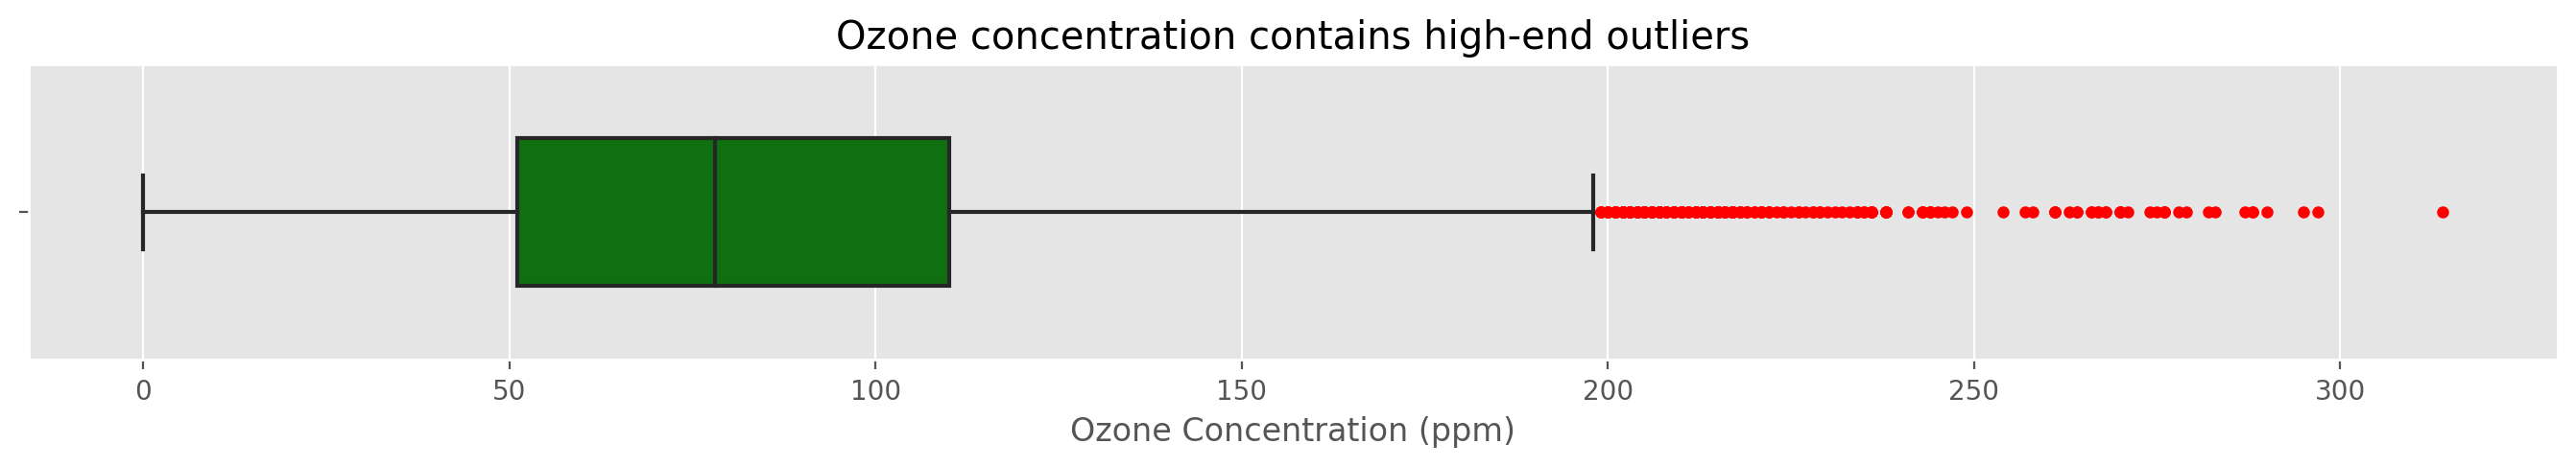

In [698]:
plt.figure(figsize=(17, 2), dpi=200)
sns.boxplot(x=df['o3'], color='green', width=0.5, 
            flierprops=dict(marker='.', markerfacecolor='red', 
                            markeredgecolor='red', alpha=1, 
                            markersize=7))

plt.title('Ozone concentration contains high-end outliers')
plt.xlabel('Ozone Concentration (ppm)')
plt.show()

In [699]:
def detect_outliers(df, column_name):
    Q1 = df[column_name].quantile(0.25)
    Q3 = df[column_name].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df.loc[(df[column_name] < lower_bound) | (df[column_name] > upper_bound)]
    num_outliers = len(outliers)
    total_rows = len(df)
    print(f"The number of outliers is {num_outliers} or {(num_outliers / total_rows * 100):.2f}% of the total data ({total_rows} rows).")

detect_outliers(df, 'o3')

The number of outliers is 203 or 4.39% of the total data (4626 rows).


**Note**
- While the boxplot already tells the location of the outliers, confirming insights from the histogram, the boxplot does not inform the number of outliers which is critical for making decision for the treatment.
- Given the outlier rate is moderate (4.39%), winsorization or log-transformation can be chosen. Winsorization caps the extreme values to specific thresholds to reduce the impact of the outliers. Log-transformation, on the other hand, compresses the range of values.
- But here, I consider winsorization more than log-transformation for several reasons. First, unlike log-transformation which uses log-scaled values, winsorization keeps the original range of values to preserve the data interpretability. Second, transformation can still be done if a further transformation is necessary. 

In [700]:
# Cap the outliers
df['o3'] = mstats.winsorize(df['o3'], limits=[0, 0.05])

In [701]:
# detect outliers
detect_outliers(df, 'o3')

The number of outliers is 0 or 0.00% of the total data (4626 rows).


### **2.6 Time Series Analysis**
This section seeks to investigate the systematicity or consistency of ozone concentration over time using time series decomposition. In general, time series consists of four components, namely level, trend, seasonality, and noise. Level represents the observed values for the data. Trend is a general pattern of the data. Seasonality denotes repeating seasonal patterns (cycles) over time. And last, noise is variability in the observation.

In [702]:
# perform seasonal decomposition
decompose_result = (seasonal_decompose(df.set_index('tanggal')['o3'], 
                                       model='additive', period=30))

**Note**: To perform time series decomposition, an additive model was used. Linear model was chosen over multiplicative one since there are some records whose ozone concentration is zero, causing an error. 

$$y(t)=\text{Level}+ \text{Trend} + \text{Seasonality} + \text{Noise}$$

#### **2.6.1 Observed Values**

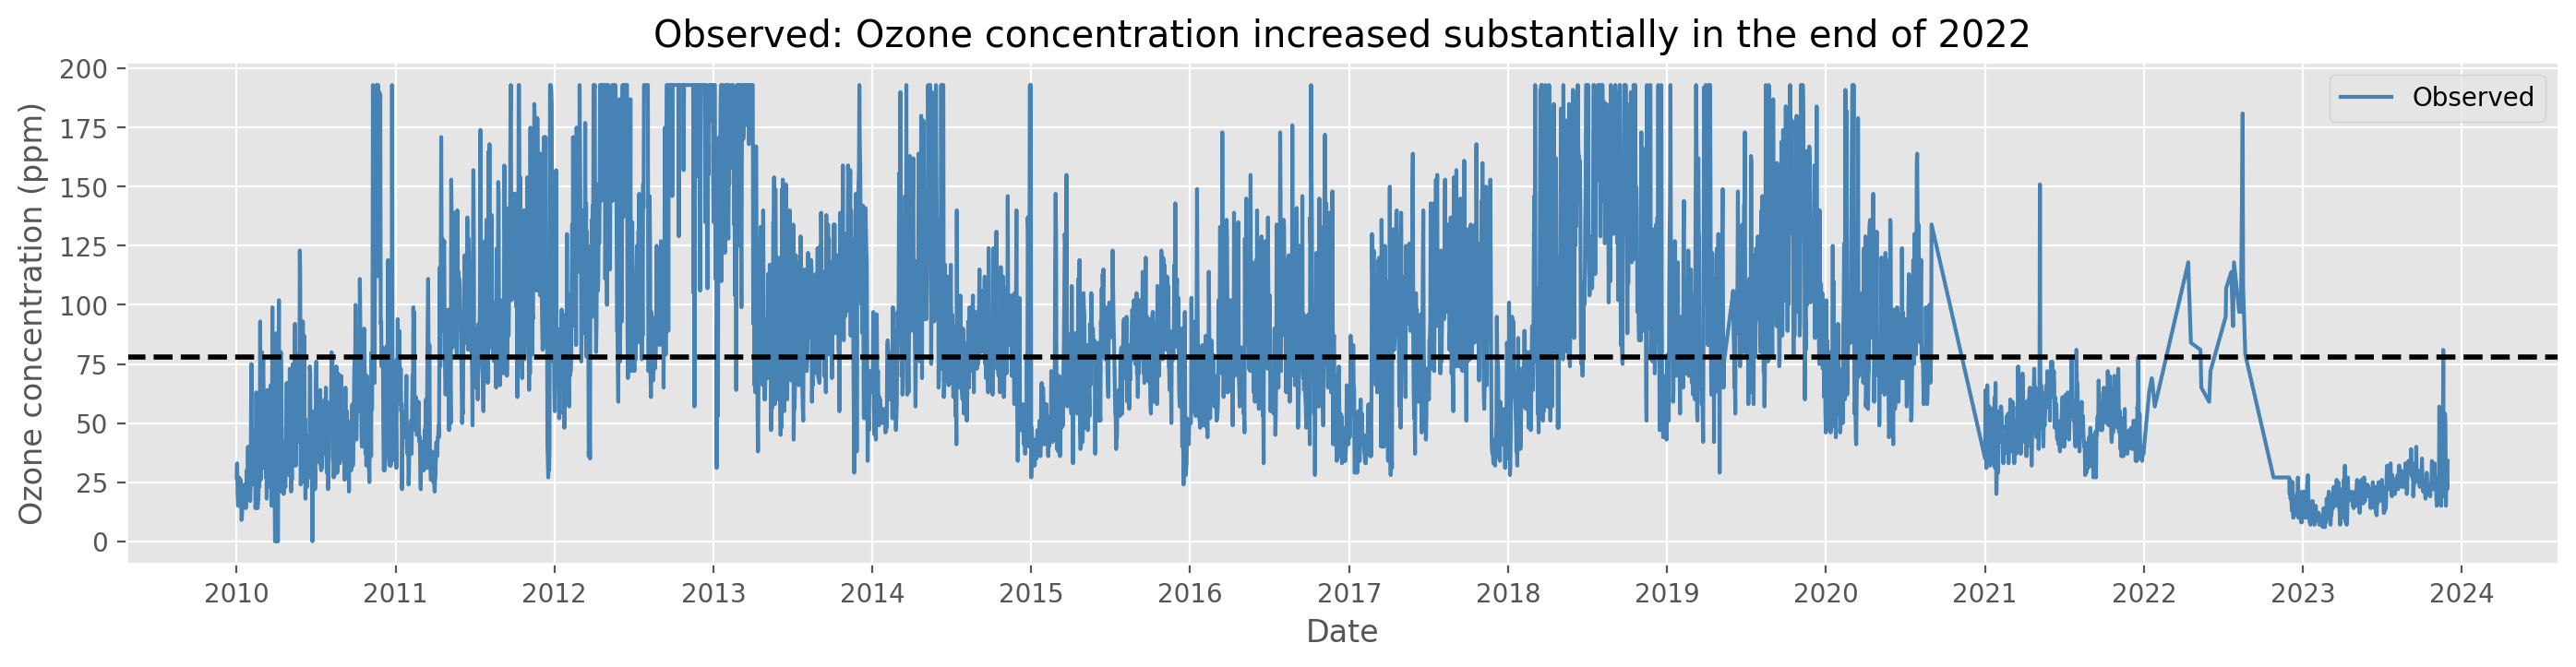

In [703]:
# plot observed values
plt.figure(figsize=(17, 4), dpi=200)
decompose_result.observed.plot(legend=True, color='steelblue', label='Observed')
plt.axhline(y=df['o3'].median(), color='black', linestyle='--', linewidth=2)
plt.title('Observed: Ozone concentration increased substantially in the end of 2022')
plt.xlabel('Date')
plt.ylabel('Ozone concentration (ppm)')
plt.xticks(rotation=0, ha='center')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())             # set tick locations to every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))     # format ticks as year
plt.show()

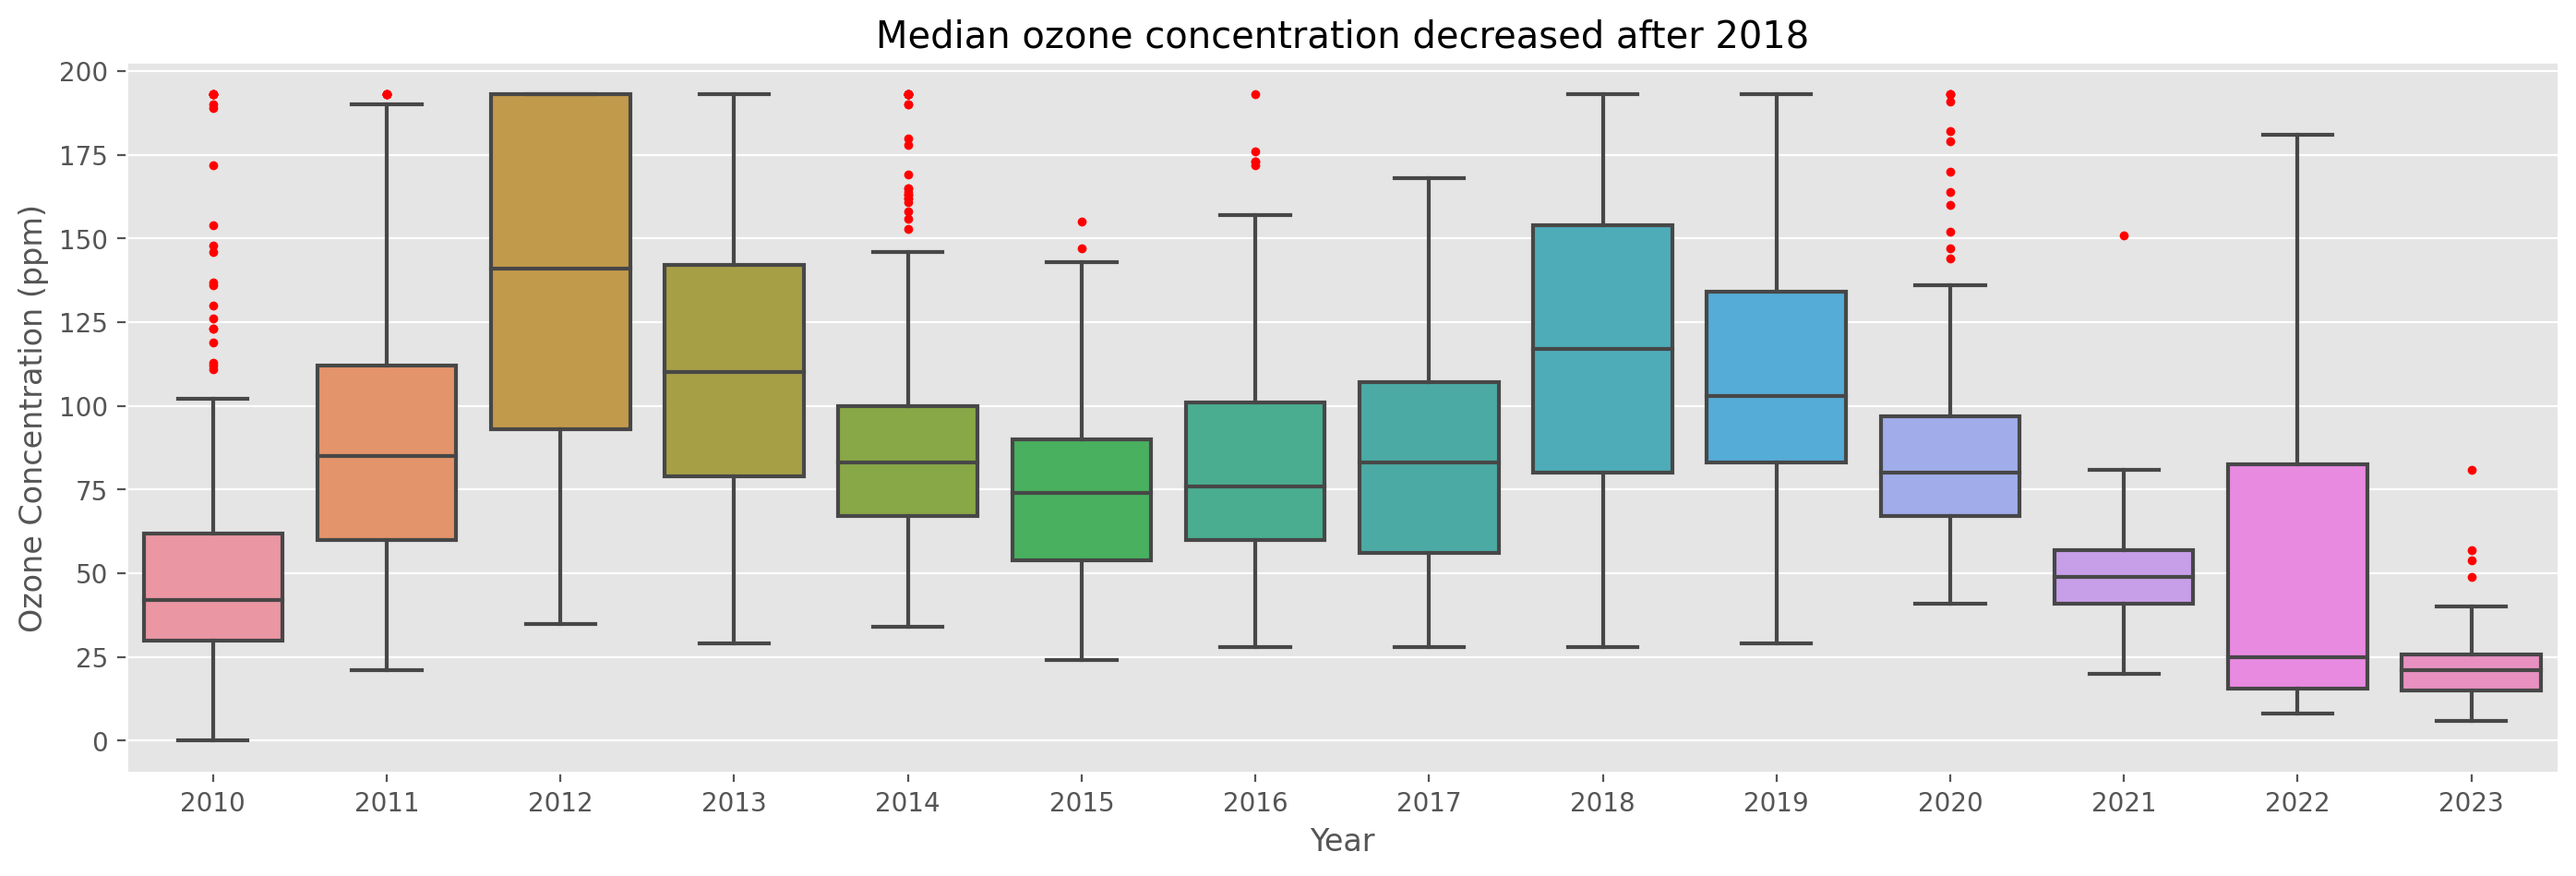

In [704]:
# extract year
df['year'] = df['tanggal'].dt.year

plt.figure(figsize=(17, 5), dpi=200)
sns.boxplot(x='year', y='o3', data=df,
            flierprops=dict(marker='.', markerfacecolor='red', 
                            markeredgecolor='red', alpha=1, 
                            markersize=5))
plt.title('Median ozone concentration decreased after 2018')
plt.xlabel('Year')
plt.ylabel('Ozone Concentration (ppm)')
plt.show()

**Note**
- The ozone concentration varies across  different years. Some years have higher median levels than others, especially in 2012 and 2018, indicating a greater overall concentration of ozone during those periods.
- Outliers remain present in the data when being subset annually. These outliers represent extreme concentrations significantly deviate from the typical values of a certain year.

#### **2.6.1 Trend in Ozone Concentration**

In [705]:
# subset 2012 data
subset2012 = decompose_result.trend.reset_index(name='o3')
subset2012 = subset2012[subset2012['tanggal'].dt.year==2012]

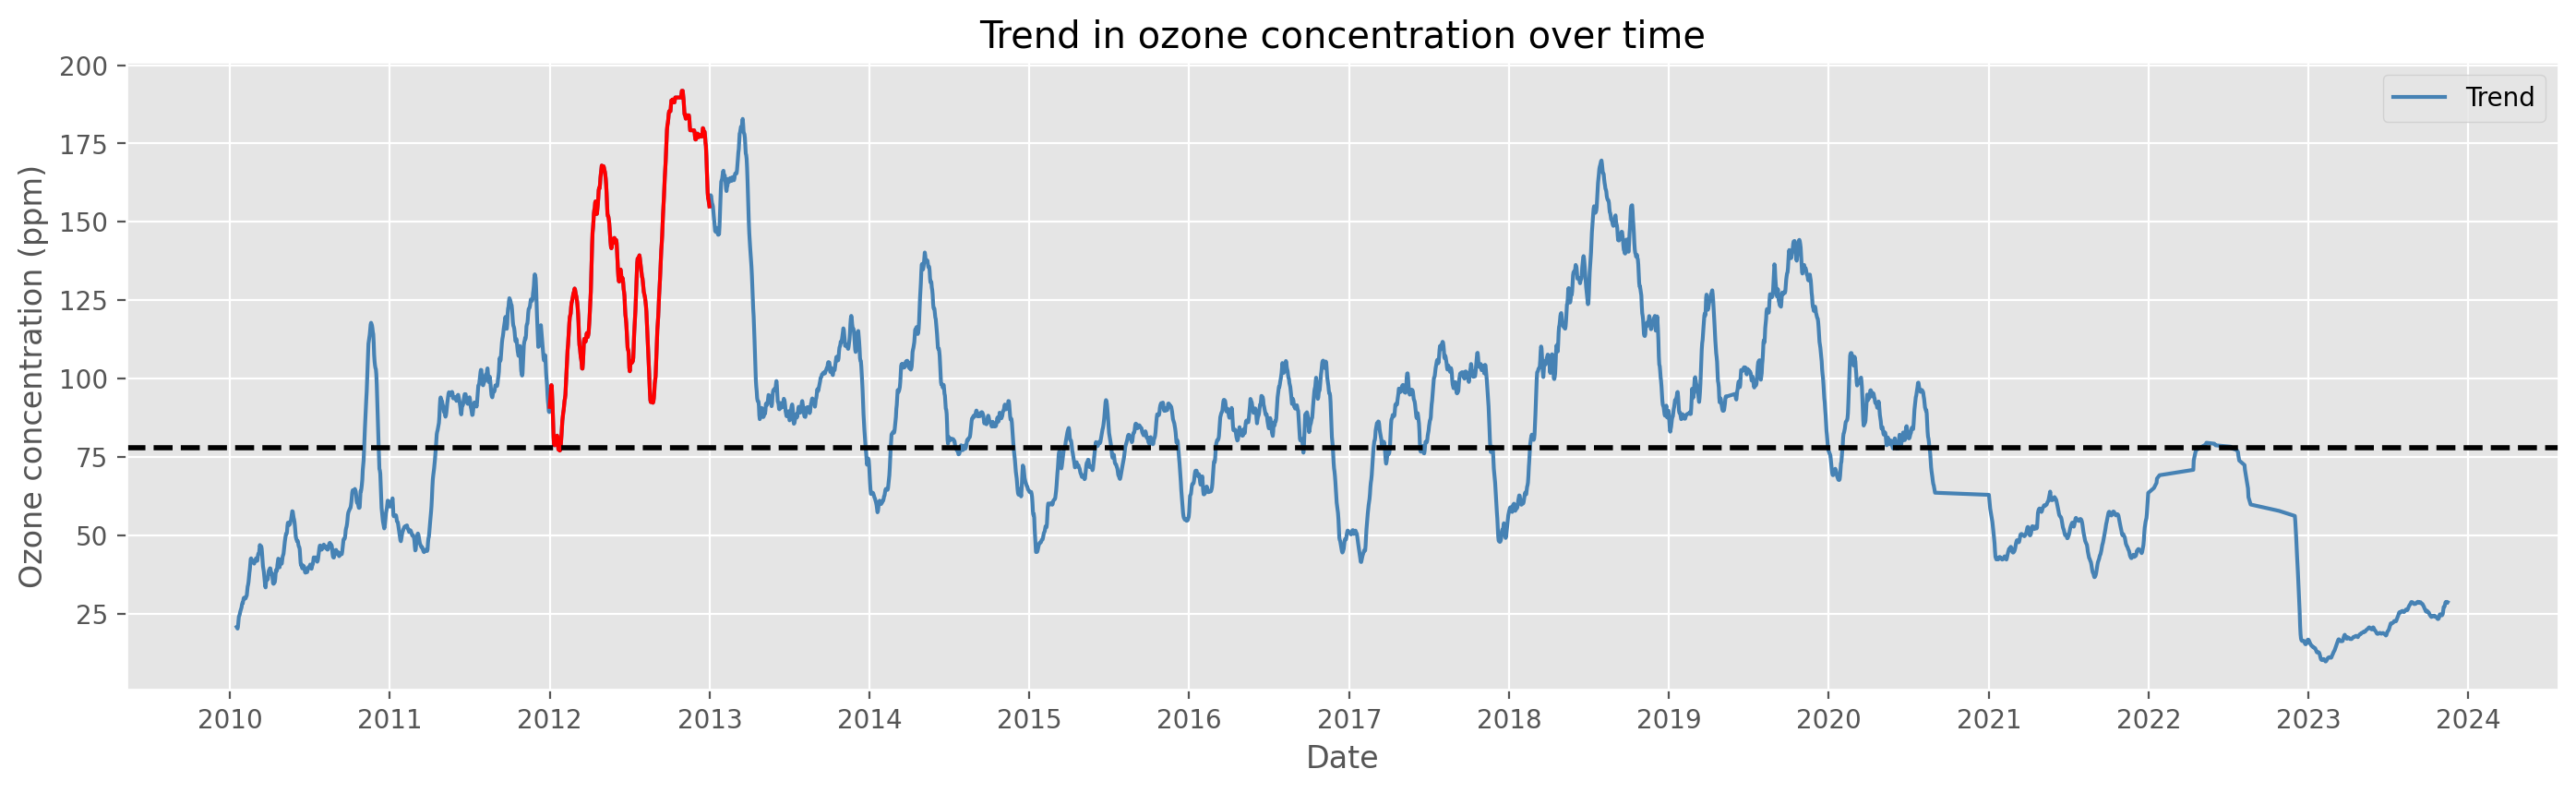

In [706]:
# plot trend
plt.figure(figsize=(17, 5), dpi=200)
decompose_result.trend.plot(legend=True, color='steelblue', label='Trend')
plt.plot(subset2012['tanggal'], subset2012['o3'], color='red')
plt.axhline(y=df['o3'].median(), color='black', linestyle='--', linewidth=2)
plt.title('Trend: No consistent trend in ozone concentration over time')
plt.title('Trend in ozone concentration over time')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())          # Set tick locations to every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Format ticks as year
plt.xlabel('Date')
plt.ylabel('Ozone concentration (ppm)')
plt.xticks(rotation=0, ha='center')
plt.show()

**Note**
- The overall trend of ozone concentration in Jakarta seems to be stable over the years, except in 2012 in which the concentration increased substantially. A further analysis can provide more details on the spike in 2012.
- After the mid 2020, the ozone concentration in Jakarta indicates a downward trend. This might indicate the environmental effects of decreasing social activities after the discovery of the first coronavirus-19 on [Mar 2, 2020](https://news.detik.com/berita/d-5964691/kasus-corona-pertama-di-indonesia-ini-kilas-balik-usai-2-tahun-berlalu) in Indonesia.
- In addition to the significant spike in 2012, there seem no regular repeating cycles. 

In [707]:
# extract year and month
df['month'] = df['tanggal'].dt.month

# filter data for 2012
df_2012 = df[df['year'] == 2012]

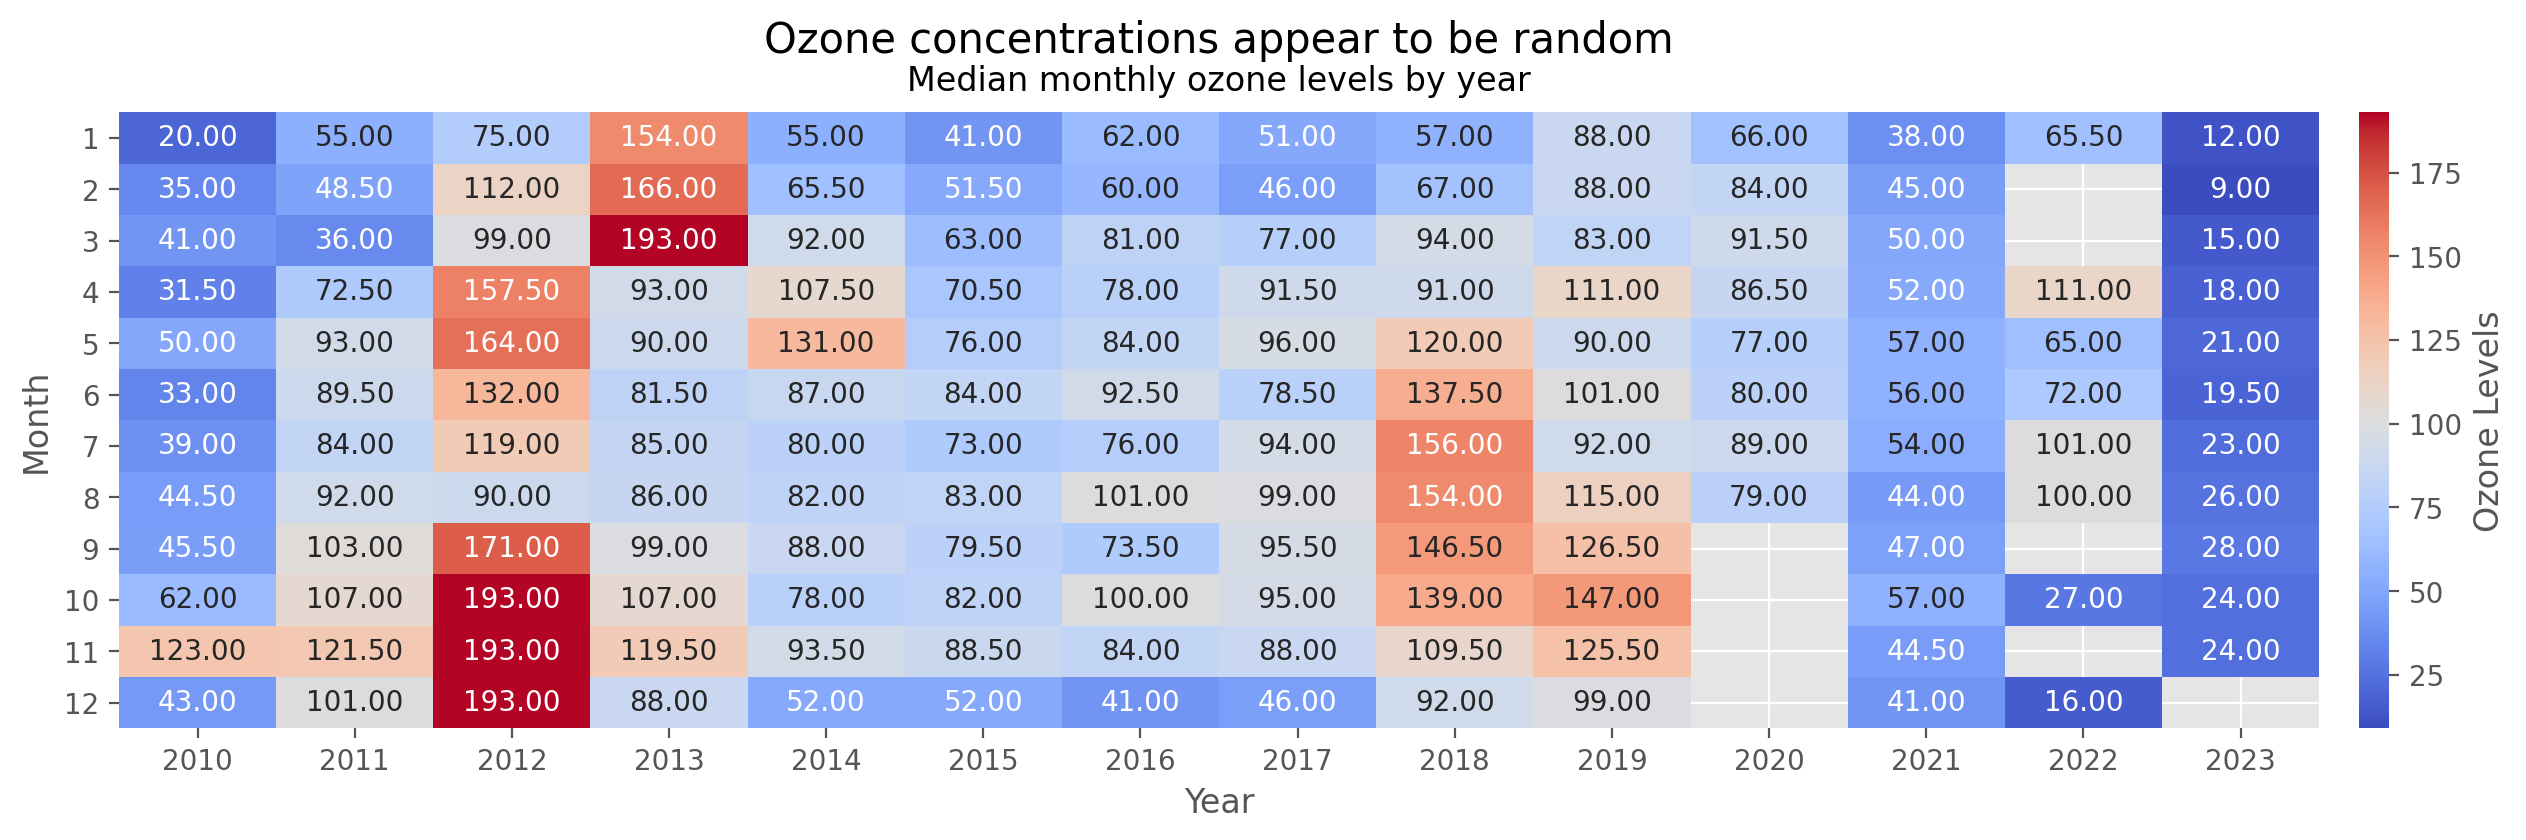

In [708]:
# Pivot the data to create a matrix of ozone levels by year and month
df_pivot = df.pivot_table(values='o3', index='month', columns='year', aggfunc='median')

# Create a heatmap
plt.figure(figsize=(17, 4), dpi=200)
sns.heatmap(df_pivot, annot=True, cmap='coolwarm', fmt=".2f", cbar_kws={'label': 'Ozone Levels', 'pad': 0.015})
plt.title('Ozone concentrations appear to be random', size=15, y=1.07)
plt.text(x=0.5, y=1.05, s='Median monthly ozone levels by year', 
         ha='center', va='center', size=12, transform=plt.gca().transAxes)
plt.yticks(rotation=0)
plt.xlabel('Year')
plt.ylabel('Month')
plt.show()


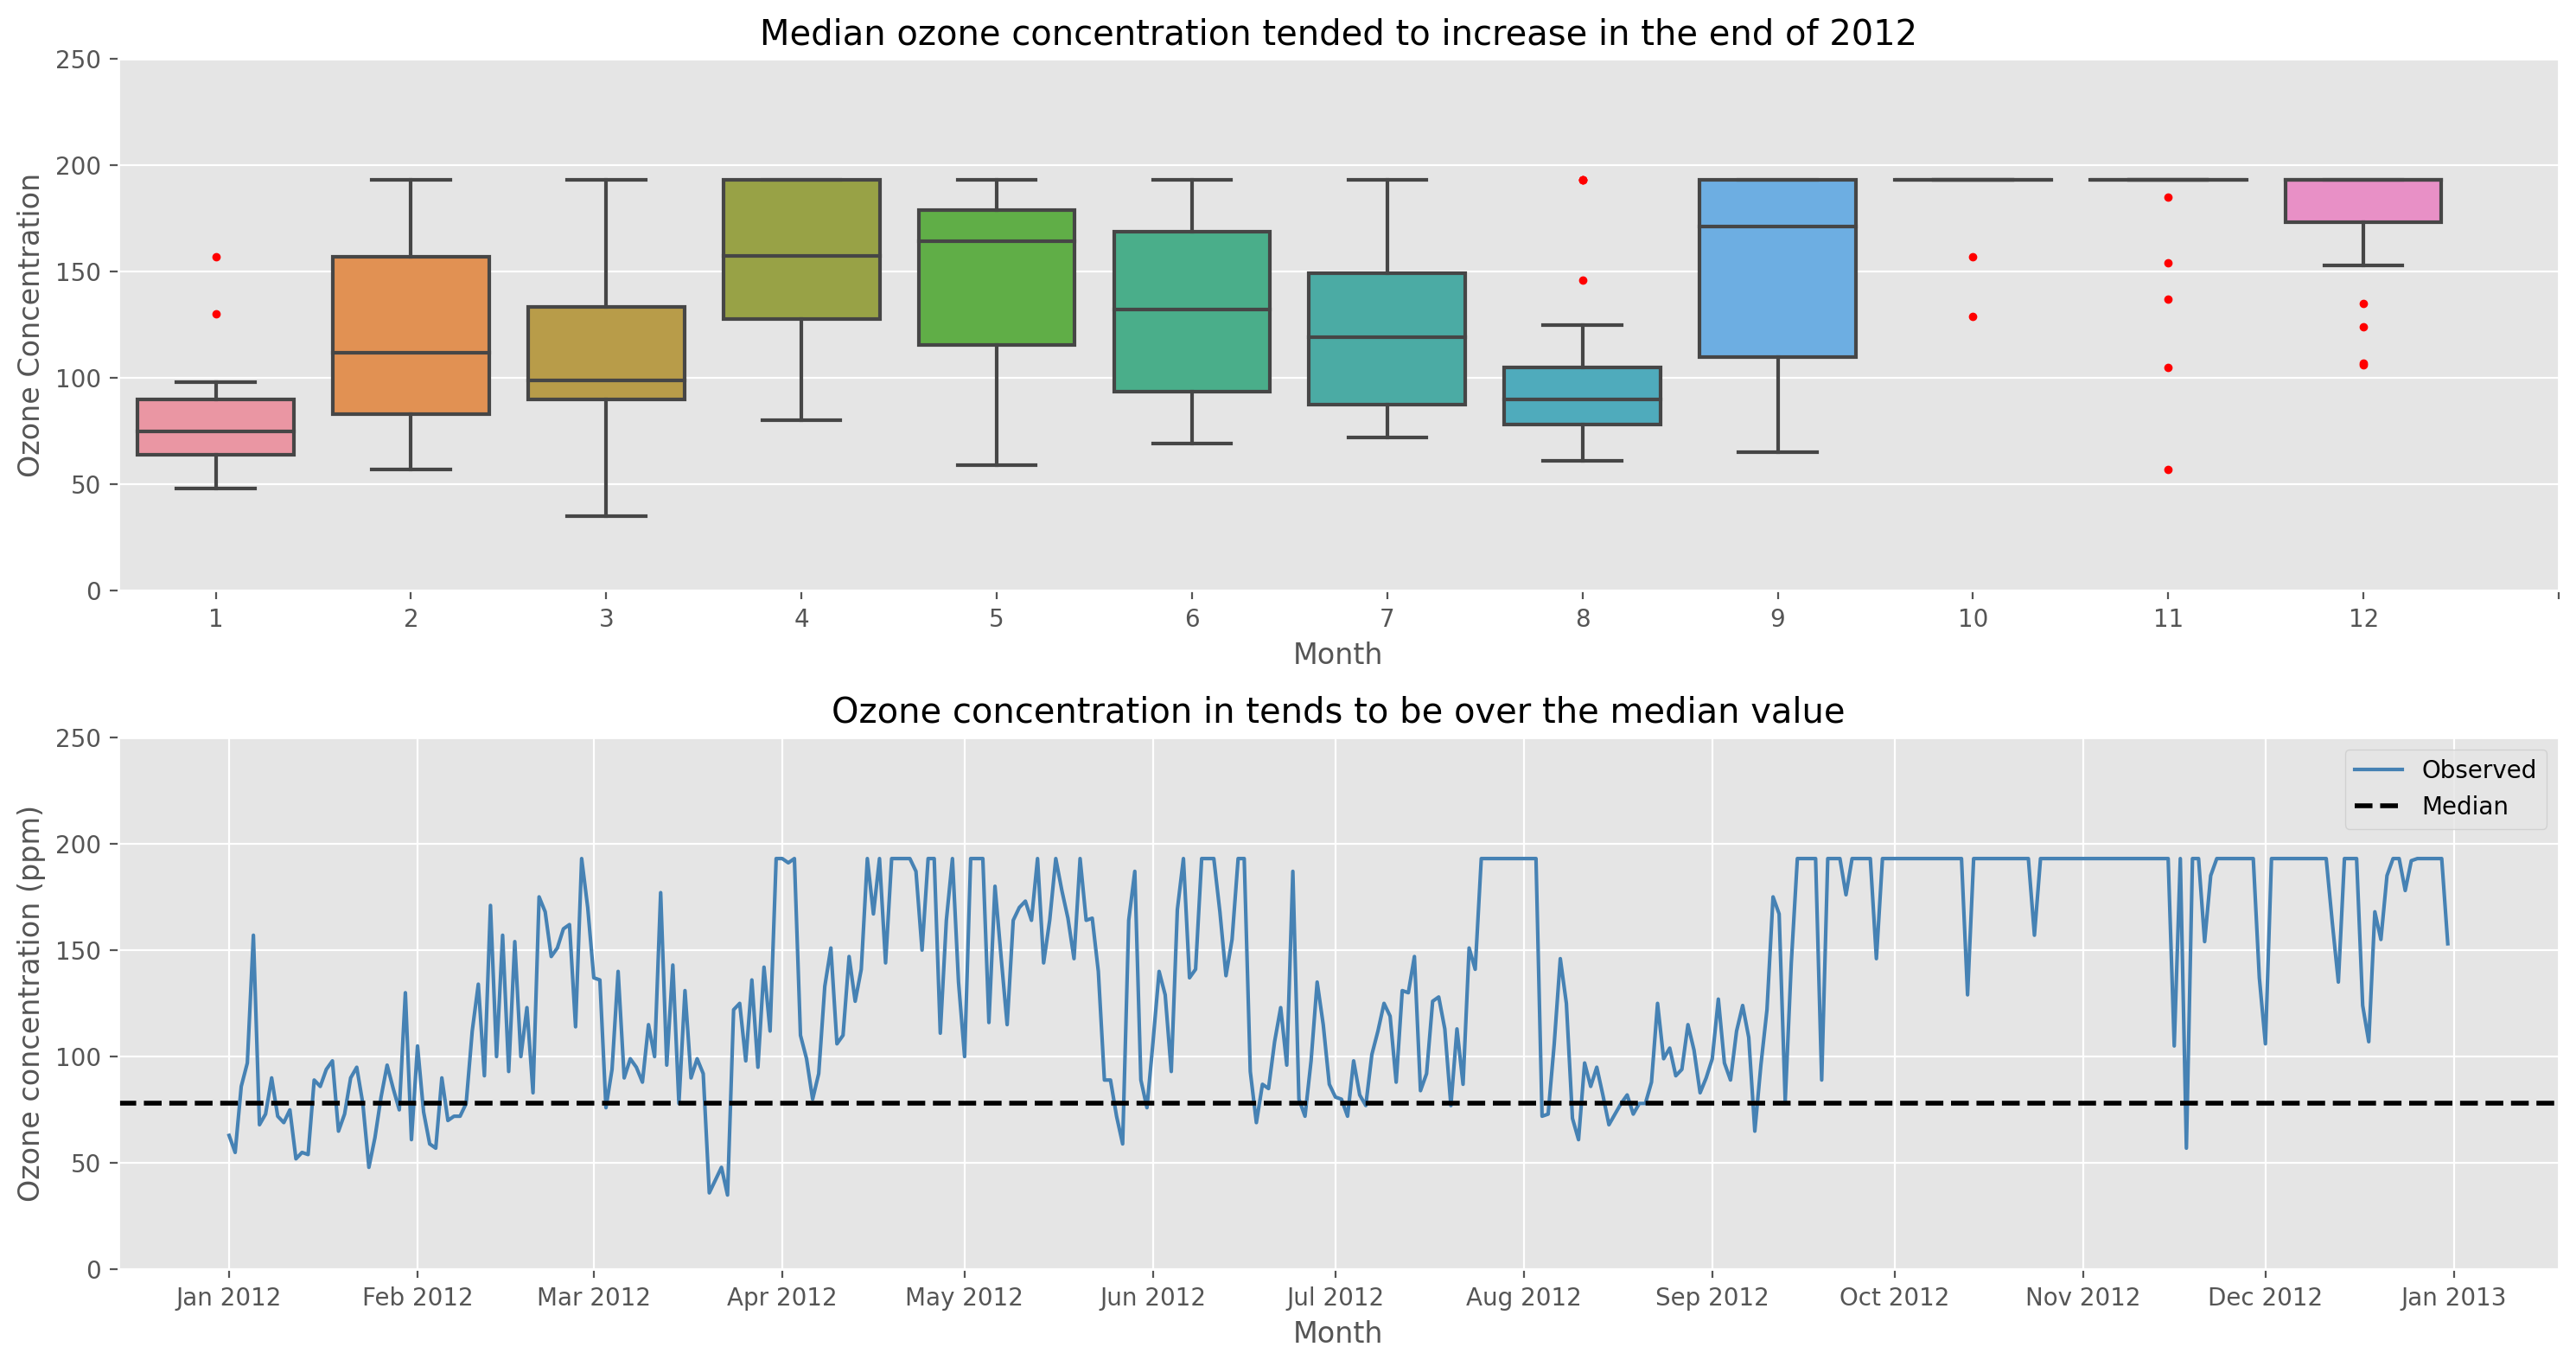

In [709]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 8), dpi=200)

# plot the boxplot 
sns.boxplot(x='month', y='o3', data=df_2012,
            flierprops=dict(marker='.', markerfacecolor='red',
                            markeredgecolor='red', alpha=1, markersize=5),
            ax=ax1)
ax1.set_xlabel('Month')
ax1.set_ylabel('Ozone Concentration')
ax1.set_title('Median ozone concentration tended to increase in the end of 2012')
ax1.set_xticks(range(0, 13))
ax1.set_ylim(0, 250)

# plot the line chart 
ax2.plot(df_2012['tanggal'], df_2012['o3'], color='steelblue', label='Observed')
ax2.axhline(y=df['o3'].median(), color='black', linestyle='--', linewidth=2, label='Median')
ax2.set_xlabel('Month')
ax2.set_ylabel('Ozone concentration (ppm)')
ax2.set_title('Ozone concentration in tends to be over the median value')
ax2.set_ylim(0, 250)
ax2.legend()

# set x-ticks to display monthly
ax2.xaxis.set_major_locator(mdates.MonthLocator())             
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))    
plt.setp(ax2.get_xticklabels(), rotation=0, ha='center')       

plt.tight_layout()
plt.show()

**Note**
- The boxplots above represents the variability of ozone concentration in 2012. In general, the ozone concentration levels in 2012 are relatively high, especially compared to the overal median of 78 ppm.
- There is considerable variation in ozone levels across different months, especially an upward trend after Aug 2012. In these months, outliers in the lower distribution are also present, indicating while month-to-month variation tends to be increasing, ozone concentrations dropped in several days.
- Since there is no information about meterological variables such as temperature, humidity, and wind speed, it is not possible to explore possible causes of these factors on the ozone concentration on the near earth surface (not in the atmosphere).

#### **2.6.3 Seasonality**

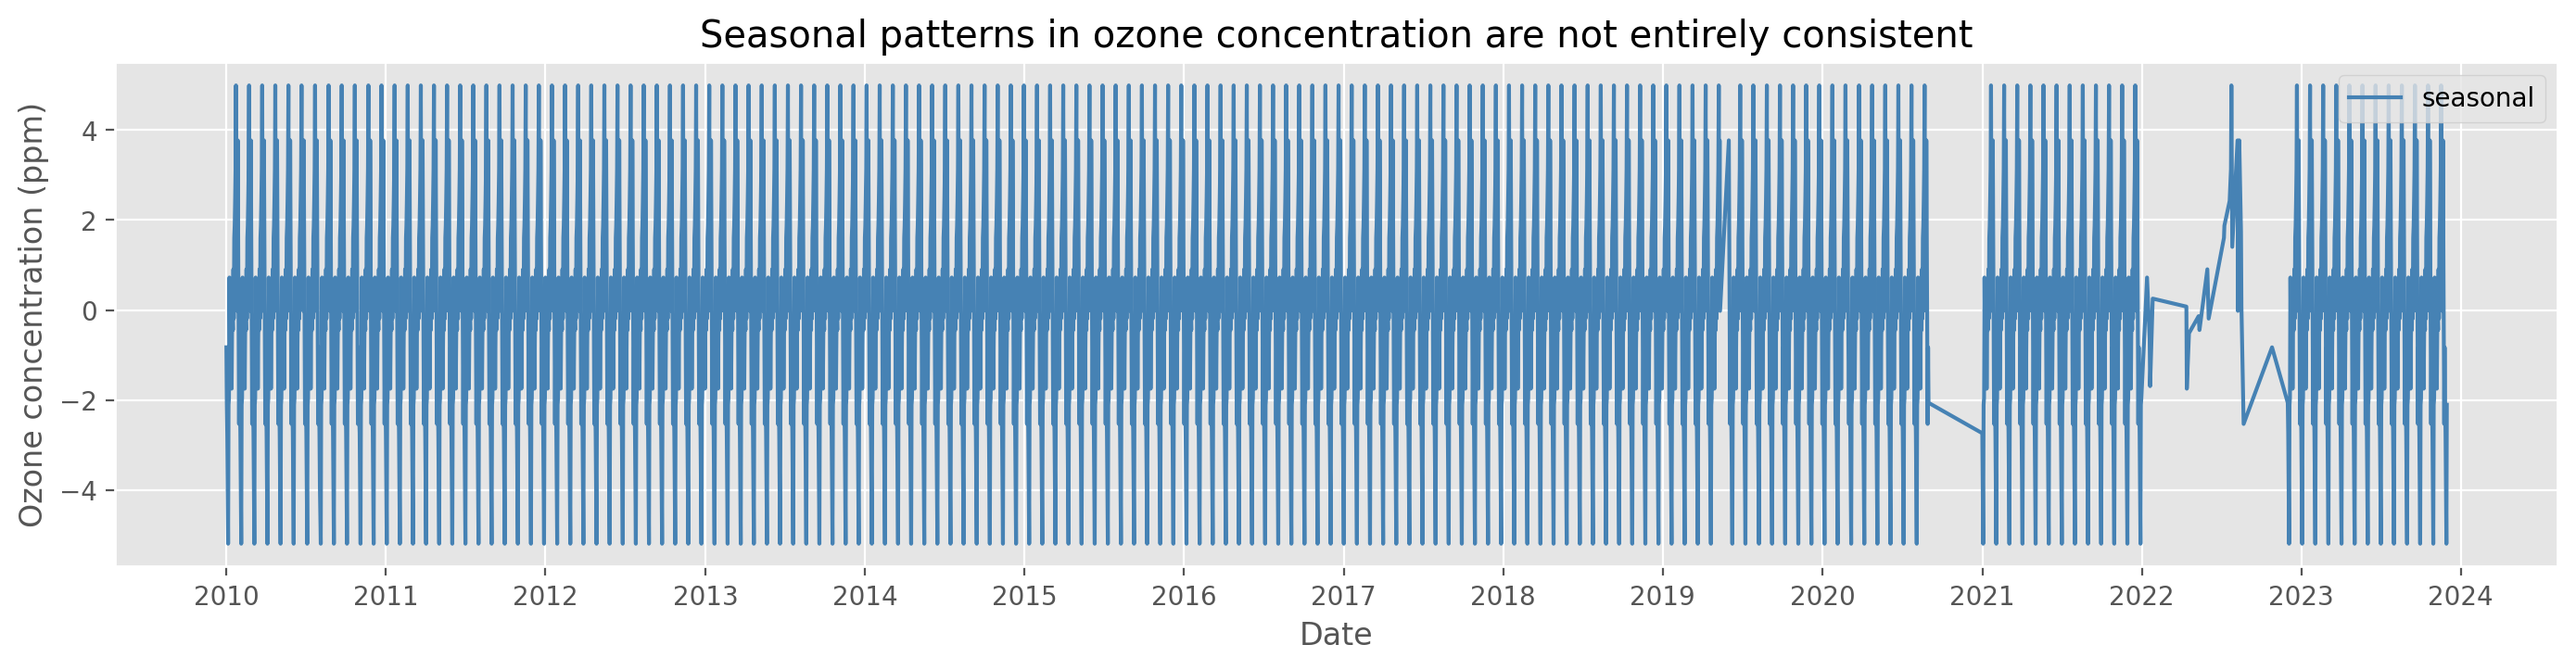

In [710]:
plt.figure(figsize=(17, 4), dpi=200)
decompose_result.seasonal.plot(legend=True, color='steelblue')
plt.title('Seasonal patterns in ozone concentration are not entirely consistent')
plt.xlabel('Date')
plt.ylabel('Ozone concentration (ppm)')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())             # Set tick locations to every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))     # Format ticks as year

plt.xticks(rotation=0, ha='center')
plt.show()

**Note**
- The seasonal component of ozone concentration exhibits a clear periodic pattern, suggesting a strong seasonal influence on ozone levels.
- However, the seasonal fluctuations seem to be vary over time. This might suggest that the strength of seasonal influences may not be entirely consistent.
- The presence of a clear seasonal pattern indicate that ozone levels can be somewhat predicted based on the time of the year.
- The implication of this insight is on the consideration of Seasonal AutoRegressive Integrated Moving Average (SARIMA) over AutoRegressive Integrated Moving Average (ARIMA) for modeling time series data with seasonal patterns.

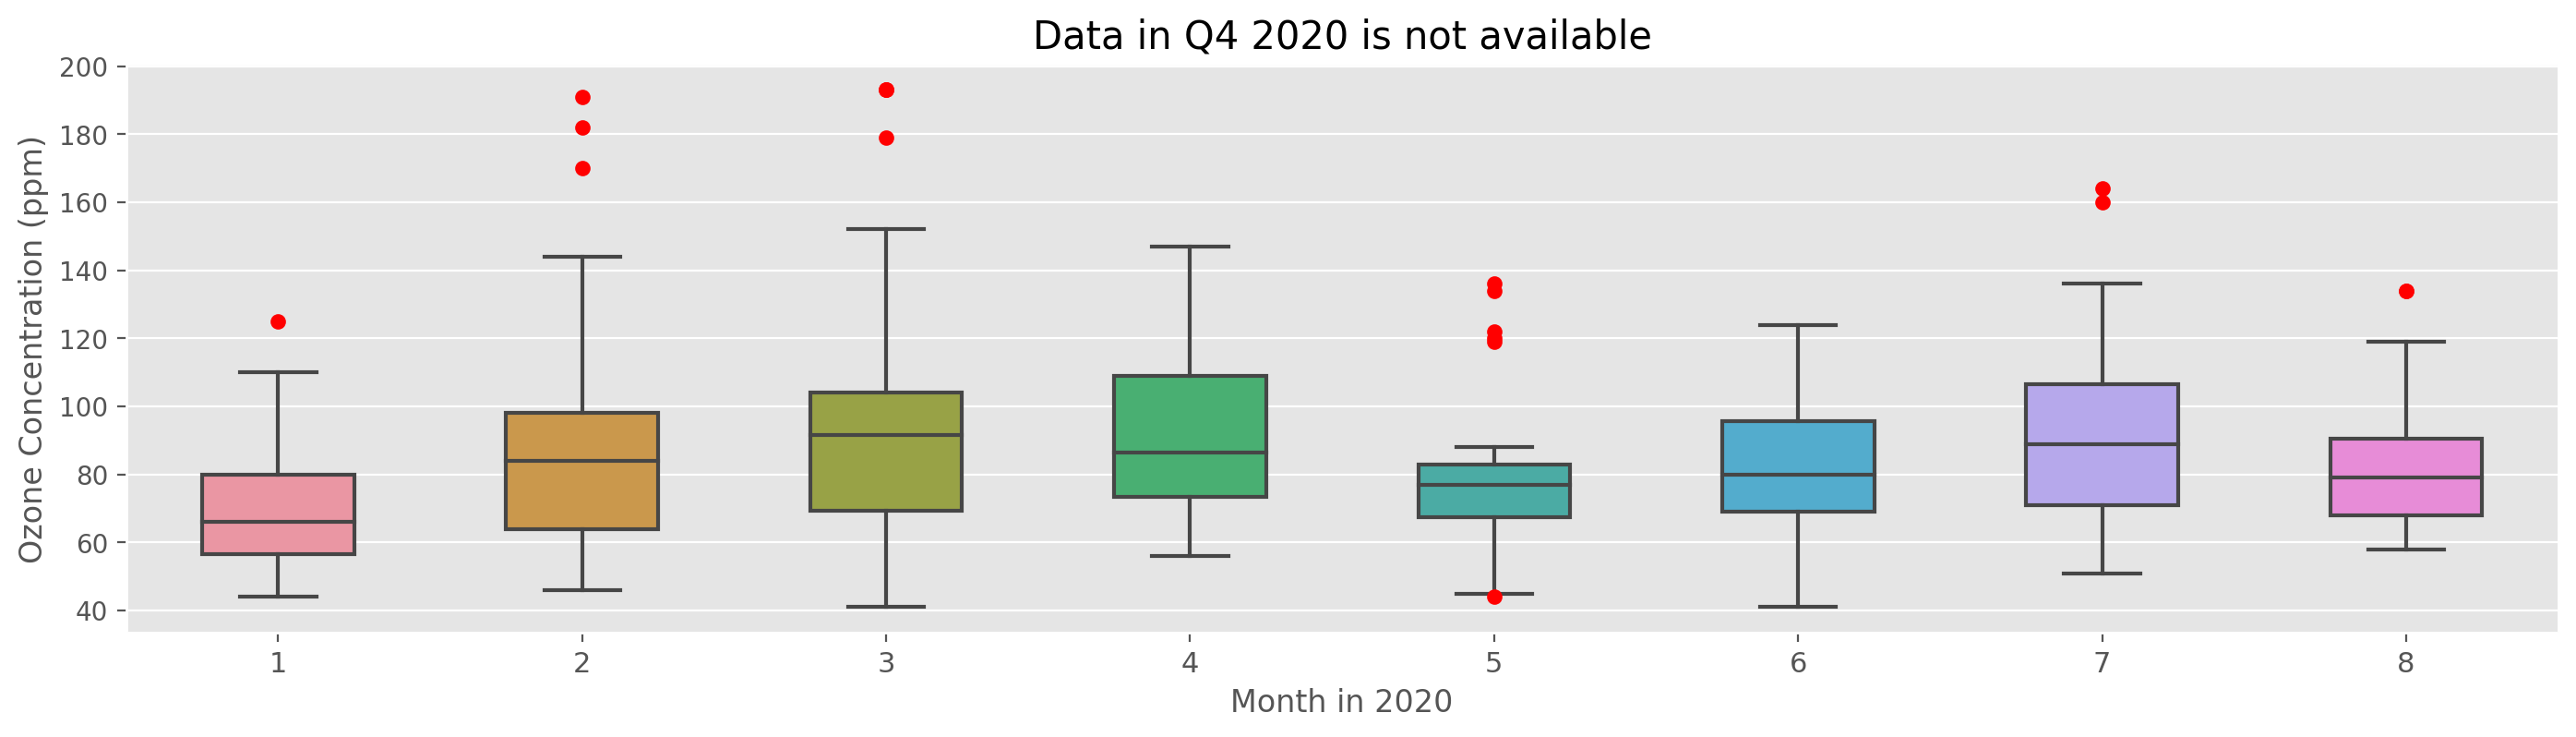

In [711]:
df_2020 = df[df['year'] == 2020]
plt.figure(figsize=(17, 4), dpi=200)
sns.boxplot(x='month', y='o3', data=df_2020, width=0.5,
            flierprops=dict(marker='.', markerfacecolor='red',
                            markeredgecolor='red', alpha=1, markersize=10))
plt.ylabel('Ozone Concentration (ppm)')
plt.xlabel('Month in 2020', size=12)
plt.title('Data in Q4 2020 is not available', size=15)
plt.xticks(size=11)
plt.show()

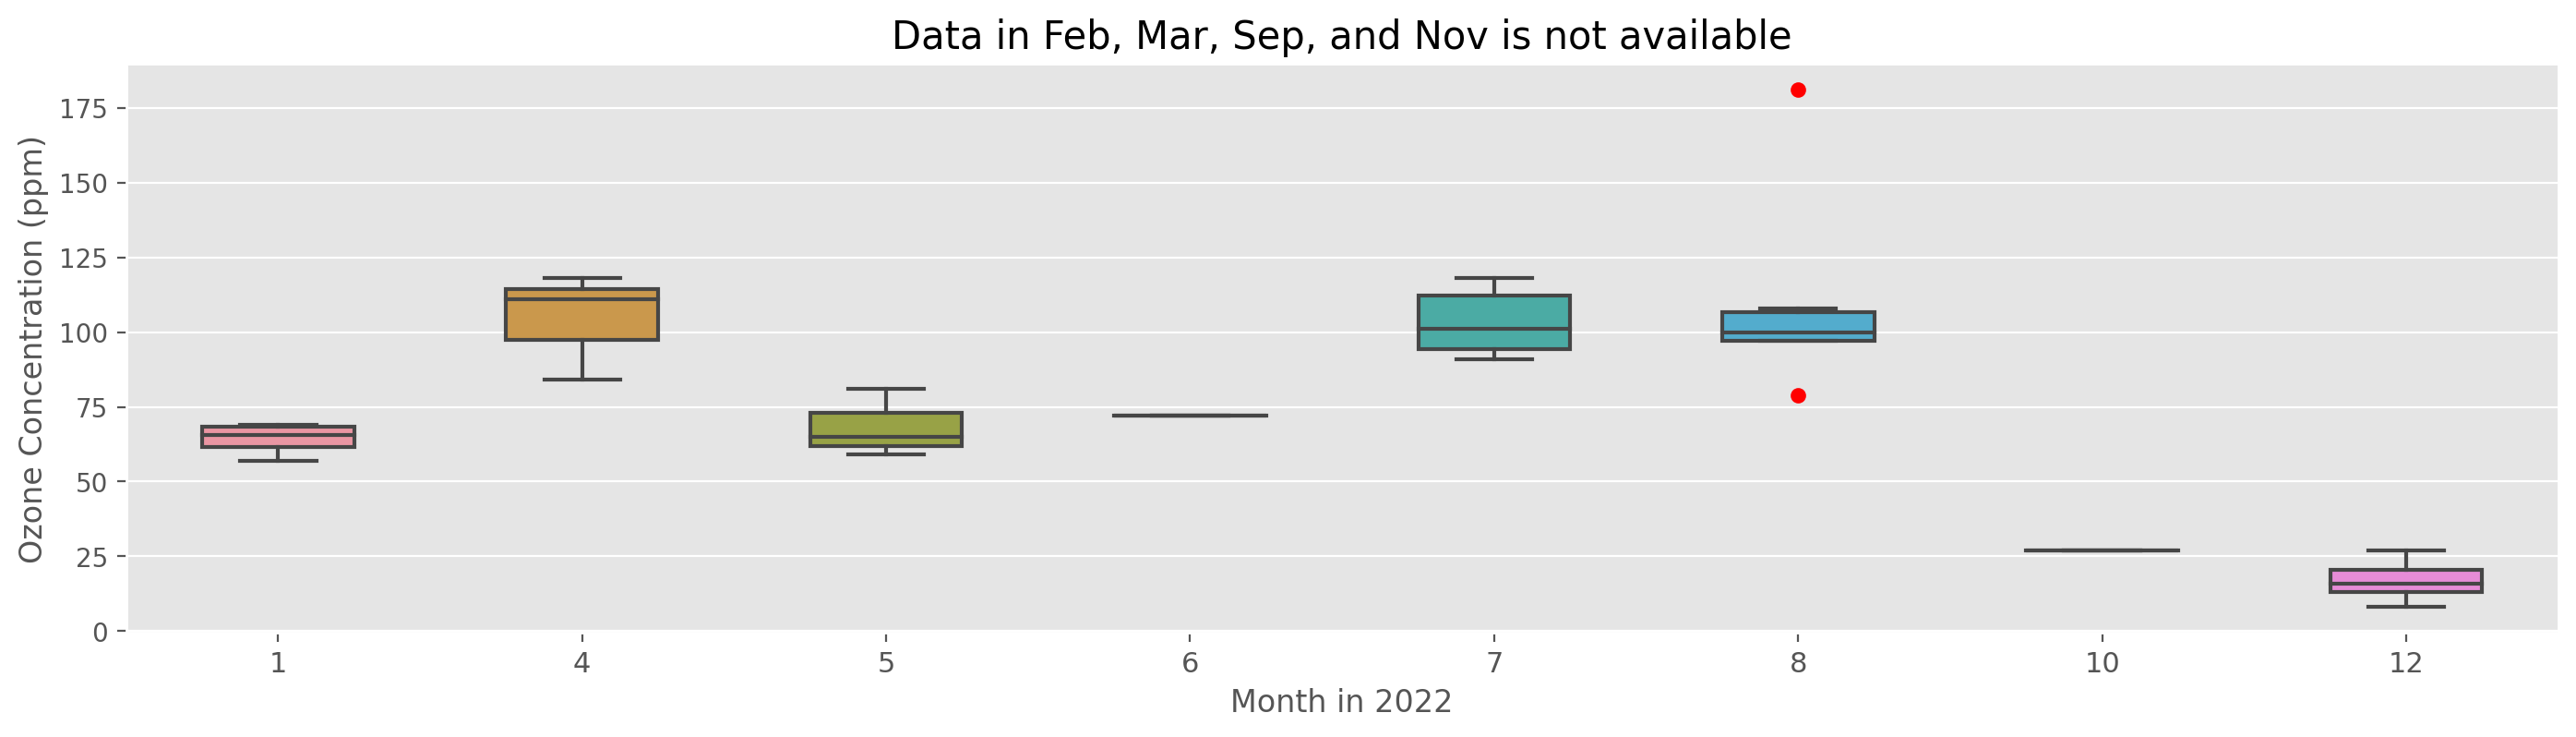

In [712]:
df_2022 = df[df['year'] == 2022]
plt.figure(figsize=(17, 4), dpi=200)
sns.boxplot(x='month', y='o3', data=df_2022, width=0.5,
            flierprops=dict(marker='.', markerfacecolor='red',
                            markeredgecolor='red', alpha=1, markersize=10))
plt.ylabel('Ozone Concentration (ppm)')
plt.xlabel('Month in 2022', size=12)
plt.title('Data in Feb, Mar, Sep, and Nov is not available', size=15)
plt.xticks(size=11)
plt.show()

#### **2.6.4 Residuals**

In [713]:
# get descriptive statistics
df['o3'].describe().round(2).to_frame().transpose()

count   mean    std  min   25%   50%    75%    max
o3  4626.0  85.05  46.28  0.0  51.0  78.0  110.0  193.0

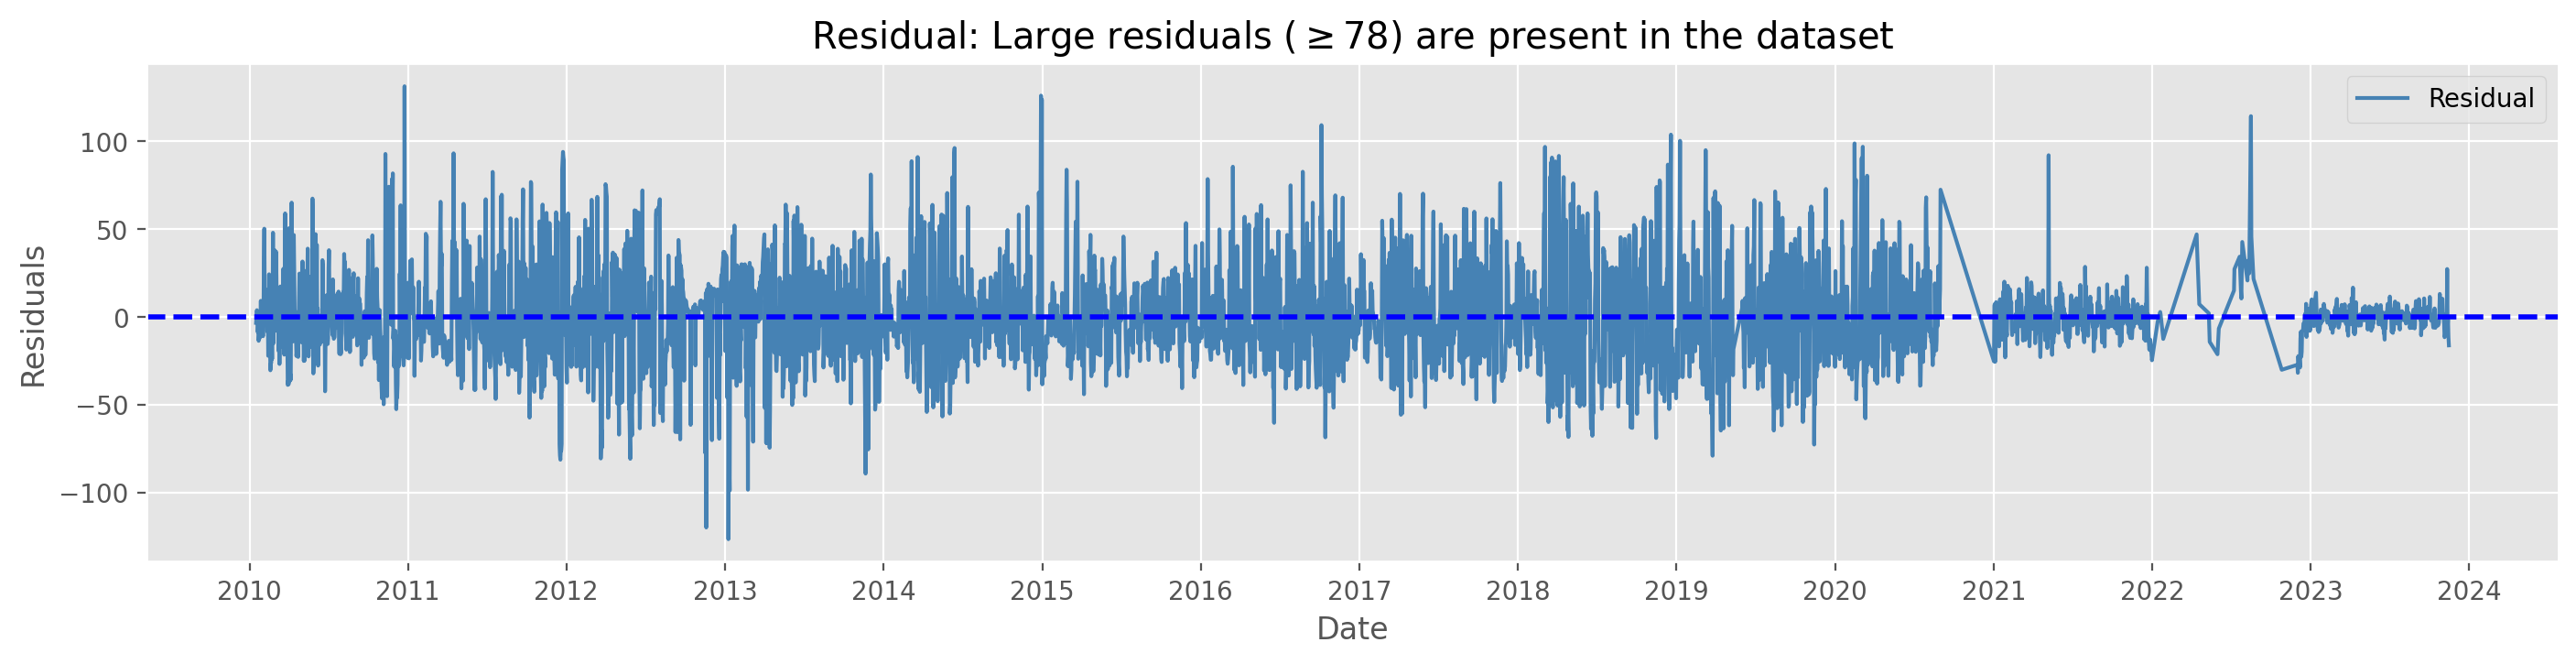

In [714]:
# plot residuals
plt.figure(figsize=(17, 4), dpi=200)
decompose_result.resid.plot(legend=True, color='steelblue', label='Residual')
plt.axhline(y=0, color='b', linestyle='--', linewidth=2)
plt.title(r'Residual: Large residuals ($\geq 78$) are present in the dataset')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.xticks(rotation=0, ha='center')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())             # Set tick locations to every year
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))     # Format ticks as year
plt.show()

**Note**: The plot in general indicates that there are still significant unexplained variations in the data that are not captured by the trend and seasonal components alone. Since the residuals show a wide range between -150 and 150, this might be the effect of outliers or anomalies.

### **2.7 Check Statitionarity**

In [715]:
# perform ADF test
def adf_test(input):
    print ('ADF test result:')
    adf_output = adfuller(input, autolag='AIC')
    result = pd.Series(adf_output[0:4], index=['ADF stat','pvalue','Lag','Nobs'])
    for i, j in adf_output[4].items():
       result[f'Critical value {i}'] = j
    display(result)

display(adf_test(df['o3']))

ADF test result:


ADF stat                -3.725726
pvalue                   0.003766
Lag                     31.000000
Nobs                  4594.000000
Critical value 1%       -3.431774
Critical value 5%       -2.862169
Critical value 10%      -2.567105
dtype: float64

None

**Note**: Since it has been stationary, no differencing is needed (`d=0`). But before implementing the `d=0`, it is strongly necessary to verify the output of the Augmented Dickey-Fuller test using Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. If this test along with autocorrelation function (ACF) indicates non-stationarity, then differencing will be applied even though ADF test tells otherwise. 

### **2.8 Check Autocorrelation**

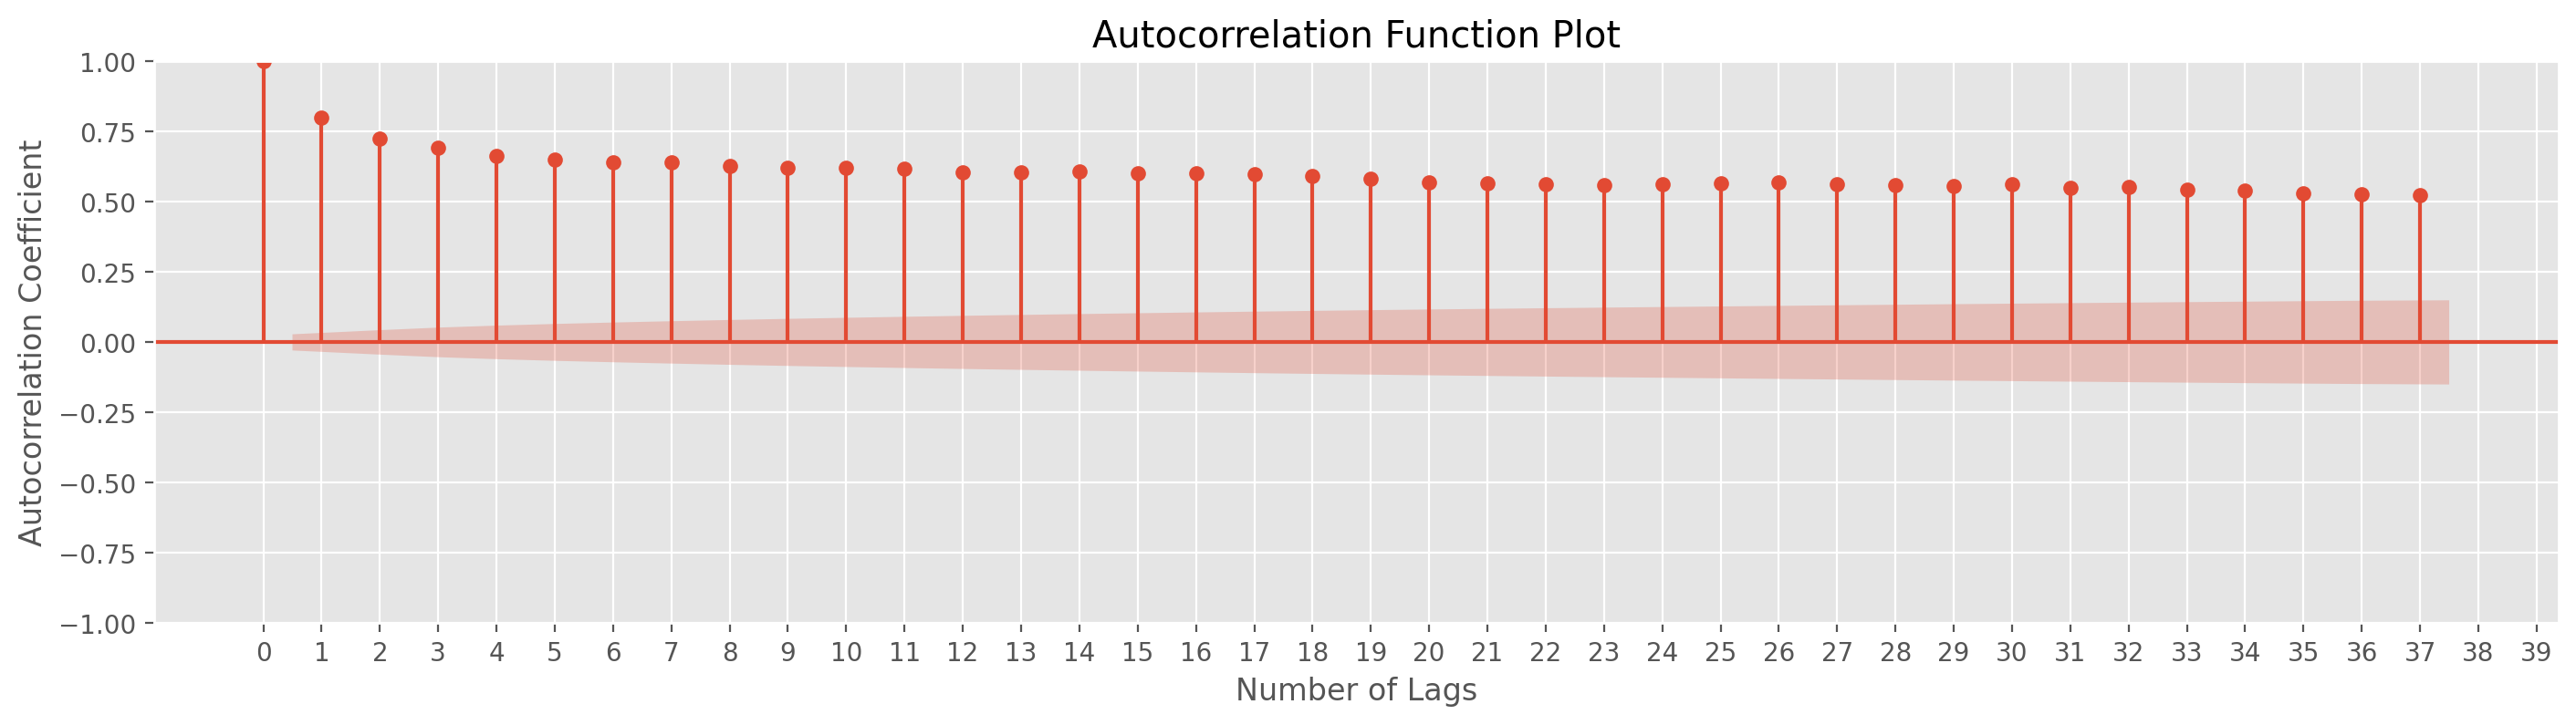

In [716]:
fig, ax = plt.subplots(figsize=(17, 4), dpi=200)  
plot_acf(df['o3'], ax=ax)
plt.title('Autocorrelation Function Plot')
plt.xlabel('Number of Lags')
plt.ylabel('Autocorrelation Coefficient')
plt.xticks(range(0, 40)) 
plt.show()

**Note**
- Based on the ACF plot, it appears that there's a strong autocorrelation at lag 1. This suggests that the value of the time series at a particular time point is significantly correlated with its value at the previous time point.
- The autocorrelation coefficient slowly decreases. This gradual decrease suggests a strong relationship between the current and past values at many lags. For this reason, this gradual decrease characterizes non-stationary series.  

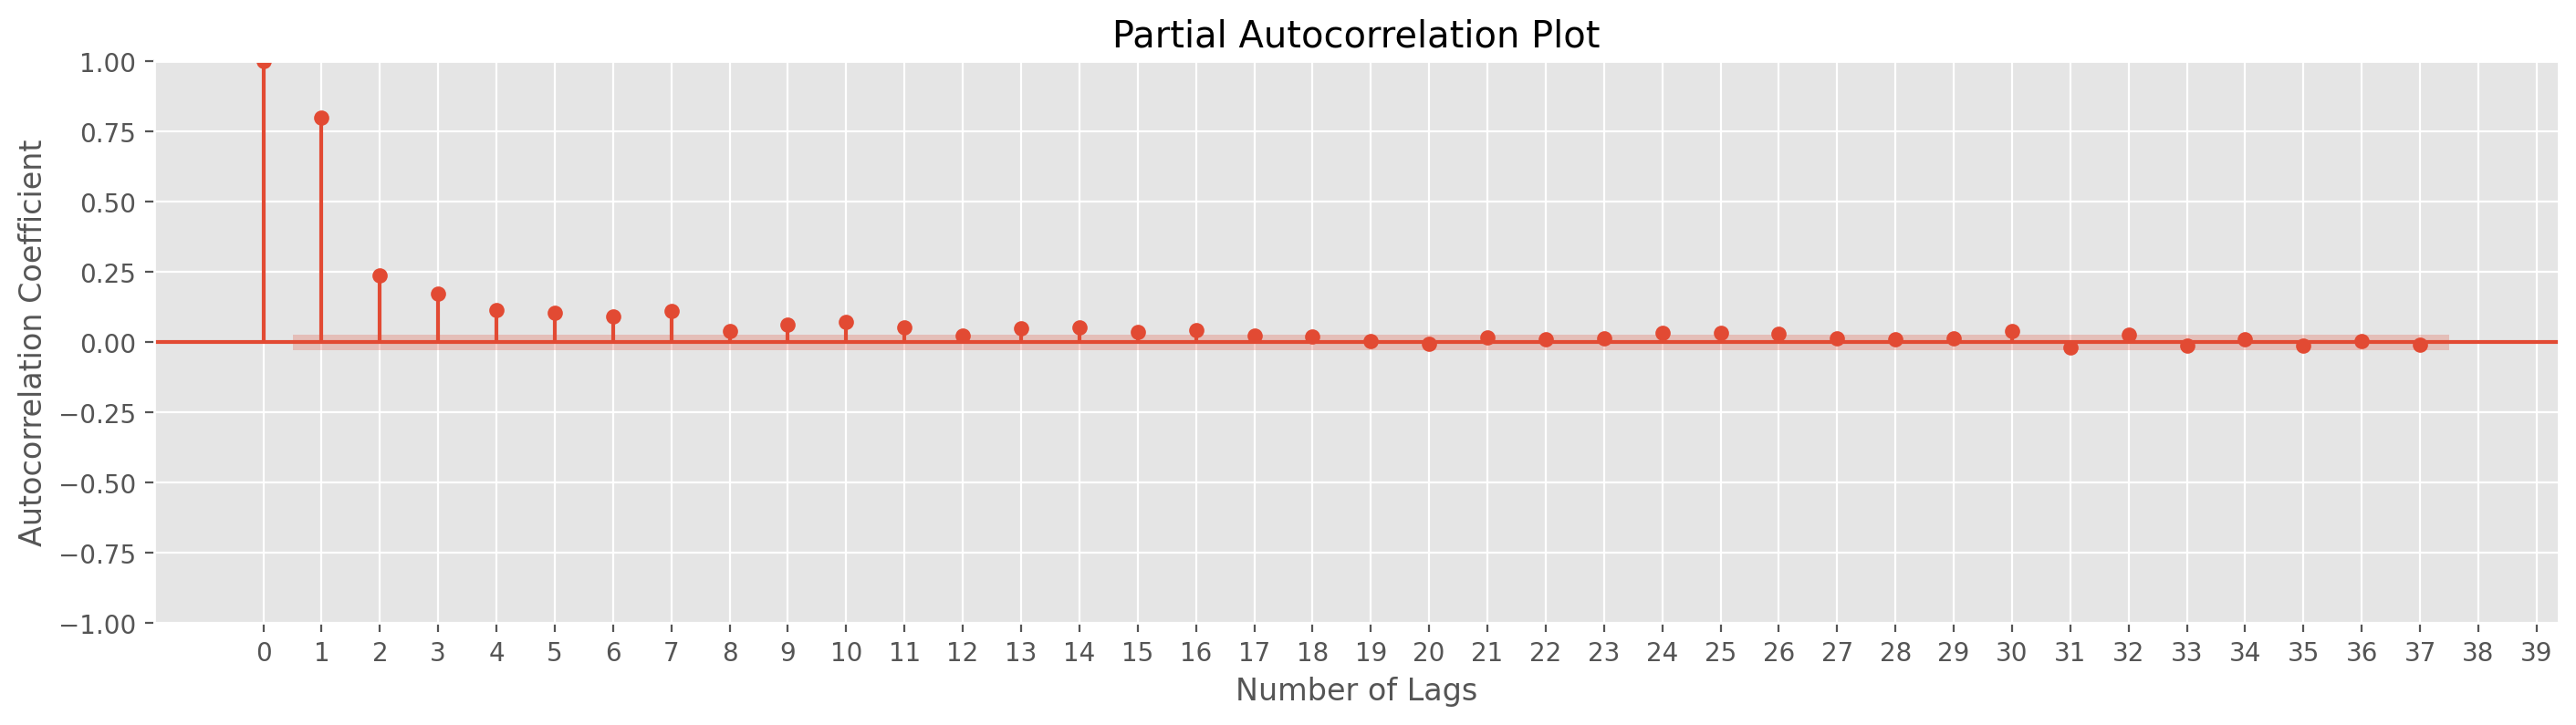

In [717]:
fig, ax = plt.subplots(figsize=(17, 4), dpi=200)  
plot_pacf(df['o3'].dropna(), ax=ax)
plt.title('Partial Autocorrelation Plot')
plt.xticks(range(0, 40)) 
plt.xlabel('Number of Lags')
plt.ylabel('Autocorrelation Coefficient')
plt.show()

## **3 Predictive Modeling**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [718]:
# drop irrelevant columns
df.drop(columns=['month', 'year'], inplace=True)

In [719]:
# Split the data into train and test sets
train_size = int(len(df) * 0.9)
train_df = df[:train_size]
test_df = df[train_size:]
print(f'Train set consists of {train_df.shape[0]} rows and {train_df.shape[1]} cols')
print(f'Train set consists of {test_df.shape[0]} rows and {test_df.shape[1]} cols')

Train set consists of 4163 rows and 2 cols
Train set consists of 463 rows and 2 cols


In [720]:
test_df.iloc[:1, :]

tanggal    o3
4163 2021-10-19  42.0

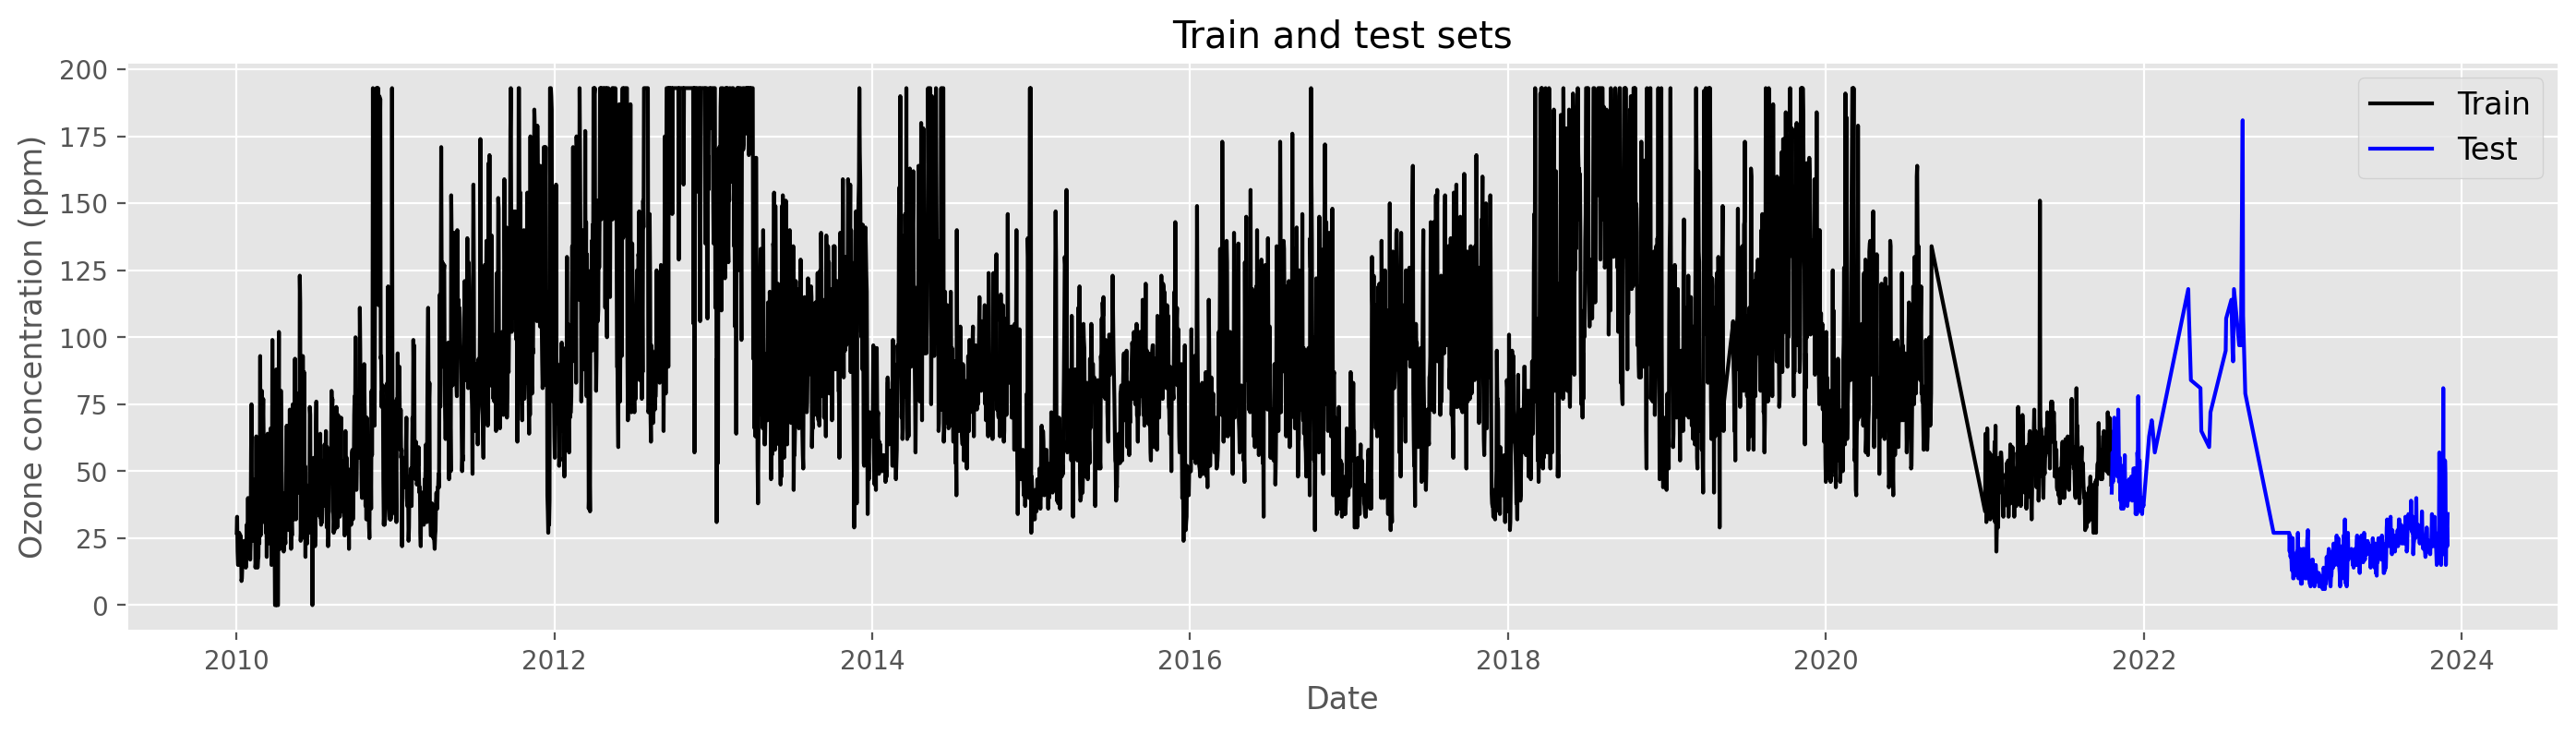

In [721]:
# visualize train and test set
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(train_df['tanggal'], train_df['o3'], color='black', label='Train')
plt.plot(test_df['tanggal'], test_df['o3'], color='blue', label='Test')
plt.xlabel('Date')
plt.ylabel('Ozone concentration (ppm)')
plt.title('Train and test sets')
plt.xticks(rotation=0, ha='center')
plt.legend(fontsize=12)
plt.show()

### **3.1 ARIMA Model**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

#### **3.1.1 Original ARIMA Model**

In [722]:
# define and fit ARIMA model with p,d,q
arima_model = ARIMA(train_df['o3'], order=(1,0,1))
arima_model = arima_model.fit()

In [723]:
# make predictions 
forecast_result = arima_model.get_forecast(steps=len(test_df))

# get pred means
predictions = forecast_result.predicted_mean

# get confidence intervals
conf_int = forecast_result.conf_int(alpha=0.05)  

In [725]:
# calculate RMSE
rmse = np.sqrt(mean_squared_error(test_df['o3'], predictions))
print(f"RMSE: {rmse:.2f}")
min_v, max_v = df['o3'].min(), df['o3'].max()
print(f"Reference: Range of ozone concentration is between {min_v} and {max_v}")

RMSE: 65.86
Reference: Range of ozone concentration is between 0.0 and 193.0


**Note**: The RMSE of the ARIMA model's predictions is quite large since the value is almost three times of the max ozone concentration value. Given this substantial value, an adjustment to the model or an experiment with another algorithm will become necessary to find out another model with lower error.

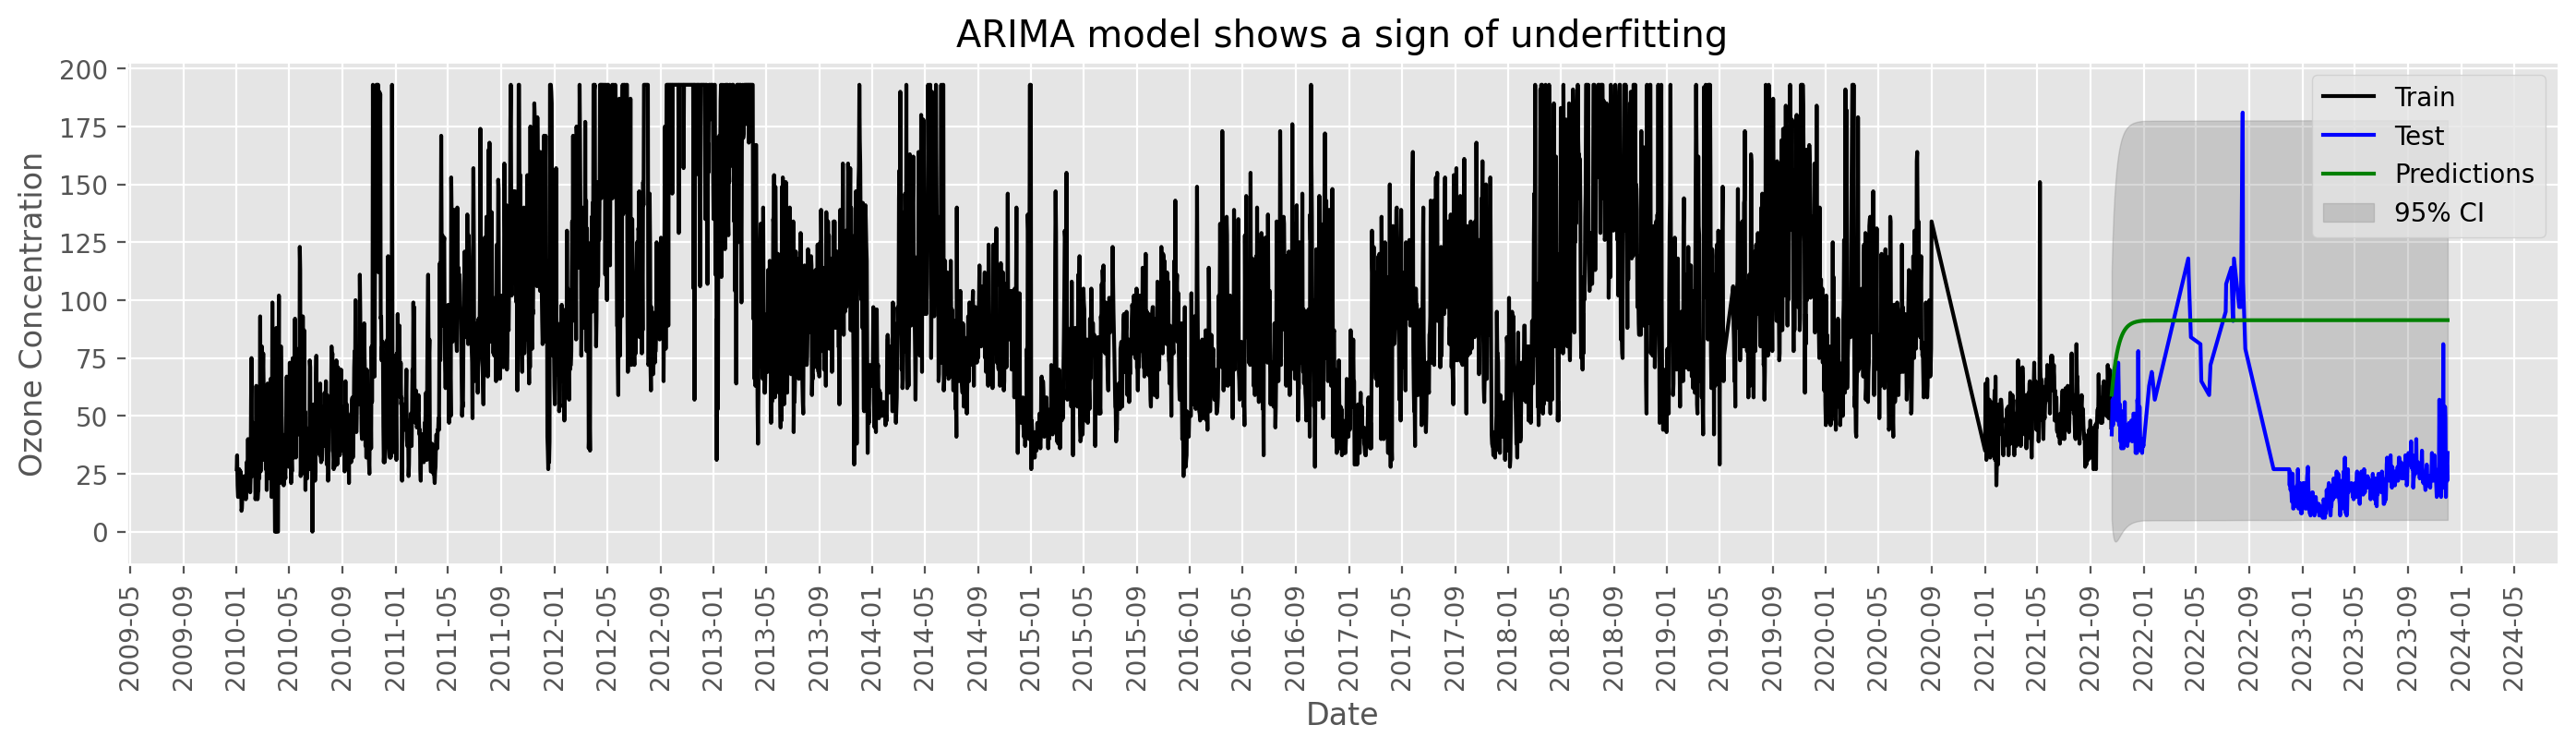

In [624]:
# plot ARIMA predictions
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(train_df['tanggal'], train_df['o3'], label='Train', color='black')
plt.plot(test_df['tanggal'], test_df['o3'], label='Test', color='blue')
plt.plot(test_df['tanggal'], predictions, label='Predictions', color='green')
plt.fill_between(test_df['tanggal'], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='95% CI')

# Set x-axis major locator to every 4 months
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.title('ARIMA model shows a sign of underfitting')
plt.xlabel('Date')
plt.ylabel('Ozone Concentration')
plt.xticks(rotation=90, ha='center')
plt.legend()
plt.show()

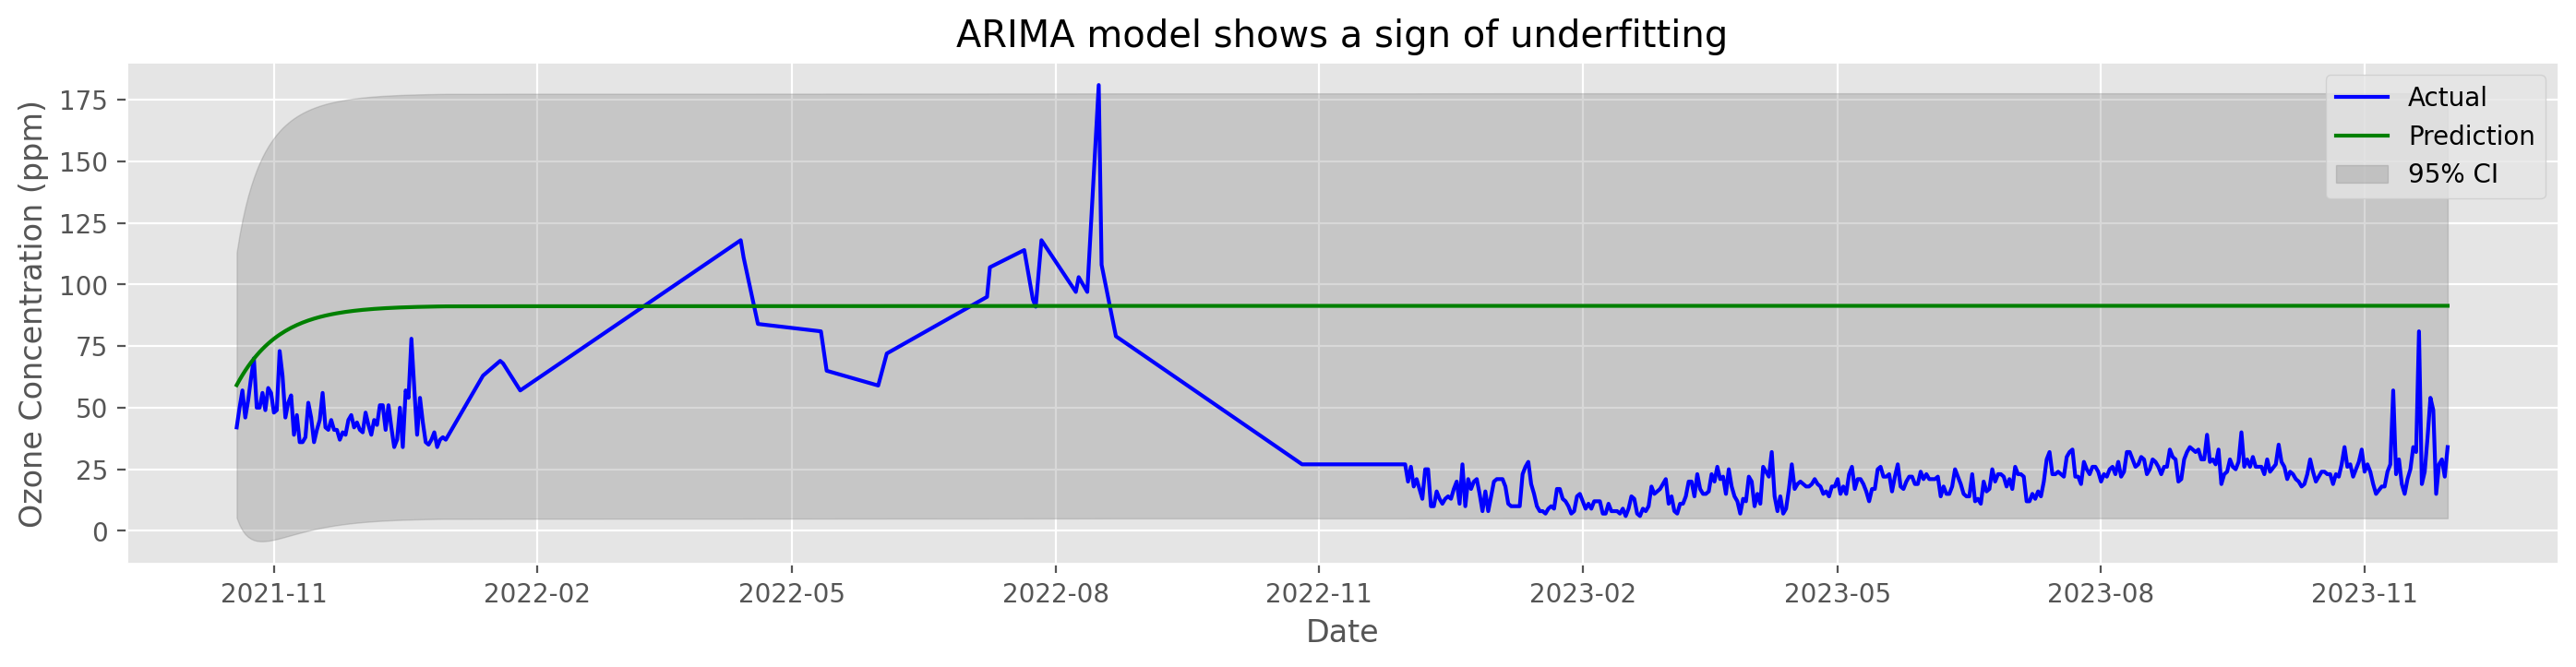

In [625]:
# plot the results
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(test_df['tanggal'], test_df['o3'], label='Actual', color='blue')
plt.plot(test_df['tanggal'], predictions, label='Prediction', color='green')
plt.fill_between(test_df['tanggal'], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.3, label='95% CI')

# set x-axis major locator to every 2 mth
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.title('ARIMA model shows a sign of underfitting')
plt.xlabel('Date')
plt.ylabel('Ozone Concentration (ppm)')
plt.xticks(rotation=0, ha='center')
plt.legend()
plt.show()

**Note**
- The ARIMA model shows a sign of underfitting. The predicted values diveerge significantly from the actual values with a flat line, indicating a failure to capture the variability in the data. This might also suggest that the model is too simple to accurately represent the underlaying patterns in the time series data.
- To improve ARIMA model's performance, an adjustment with the ARIMA parameters (`p`, `d`, and `q`) can be done. Alternatively, other algorithms such as Prophet and Long-Term Short Term Memory can be options. In this case, seasonal ARIMA (SARIMA) does not seem to be a good option since the ozone concentration does not indicate any seasonal components.

#### **3.1.2 ARIMA Model with Parameter Adjustment (AutoARIMA)**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

In [626]:
# perform auto_arima 
auto_model = pm.auto_arima(train_df['o3'], start_p=0, start_q=0, max_p=3, max_q=3, 
                           seasonal=False, trace=False, stepwise=True)
print(auto_model)

 ARIMA(3,1,1)(0,0,0)[0]          


In [627]:
# forecast using the auto_arima model
forecast, conf_int = auto_model.predict(n_periods=len(test_df), return_conf_int=True)

In [628]:
# calculate RMSE
rmse_autoarima = np.sqrt(mean_squared_error(test_df['o3'], forecast))
print(f"RMSE: {rmse_autoarima:.2f}")

RMSE: 34.09


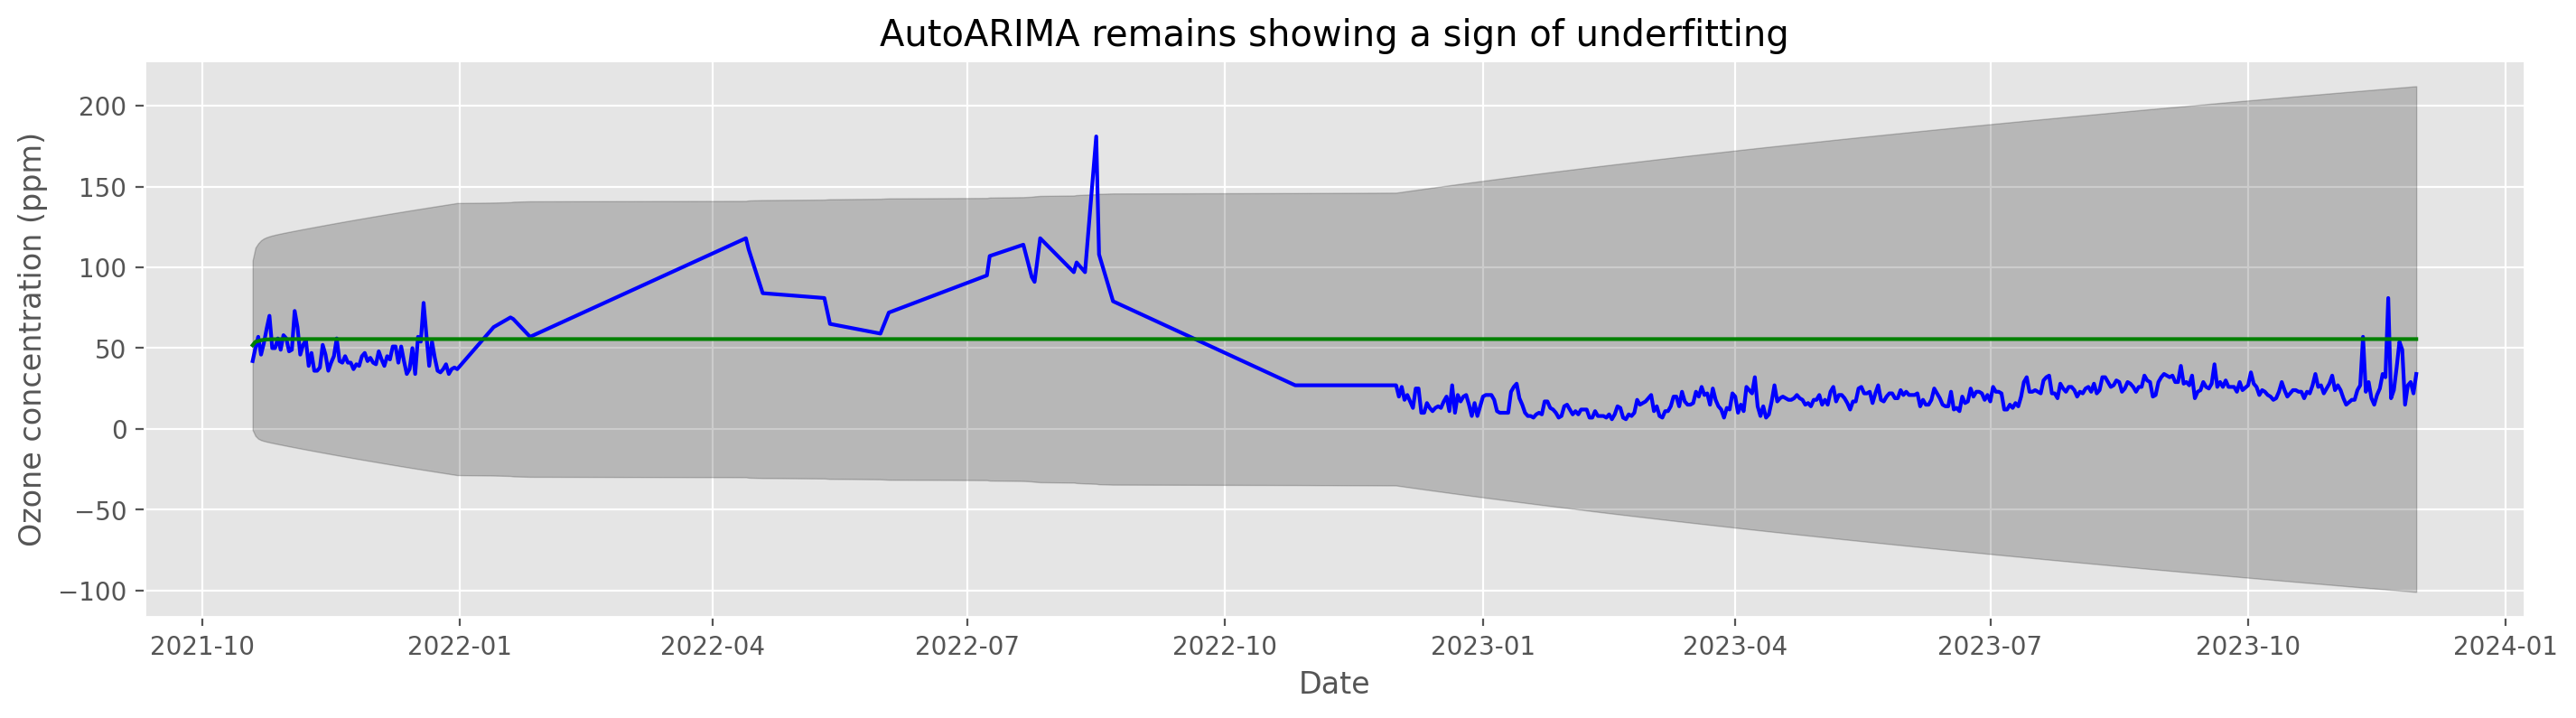

In [629]:
# plot ARIMA forecasts
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(test_df['tanggal'], test_df['o3'], label='Actual', color='blue')
plt.plot(test_df['tanggal'], forecast, label='Forecast', color='green')
plt.fill_between(test_df['tanggal'], conf_int[:, 0], conf_int[:, 1], color='k', alpha=0.2)
plt.title('AutoARIMA remains showing a sign of underfitting')
plt.xlabel('Date')
plt.ylabel('Ozone concentration (ppm)')
plt.show()

**Note**: Even though an adjustment to the order parameter has been done with `auto_arima`, the adjustment does not show a significant improvement. The only improvement shown is only the reduction to the RMSE score. The adjusted ARIMA model remains experiencing underfitting. The poor performance of these two ARIMA models might be attributed to ARIMA's limitation when dealing with long-term forecasting.

### **3.2 Prophet Model**
To address the limitations of the ARIMA models in long-term forecasting, a Prophet model will be utilized. Prophet model building is quite straightforward because it reduces manual effort to handle outliers and missing values since these have been handled automatically by [Prophet](https://facebook.github.io/prophet/).

In [630]:
df_prophet = df.copy()
df_prophet.rename(columns={'tanggal': 'ds', 'o3': 'y'}, inplace=True)

**Note**: Prophet will require specific names for the variables so the variable names `tanggal` and `o3` must be renamed into `ds` and `y`, respectively. Otherwise, there will be an error message arising. Furthermore, since the name of the variable changes, the train and test set can no longer be used. Here, the train and tests set are redefined for building the Prophet model but the instances remain the same. The first instance for testing the Prophet model is still 2021-10-19.

In [631]:
# creating the train and test set 
train_df = df_prophet[ :int(0.9*(len(df)))] 
test_df = df_prophet[int(0.9*(len(df))): ]
print(f'Train set consists of {train_df.shape[0]} rows and {train_df.shape[1]} cols')
print(f'Train set consists of {test_df.shape[0]} rows and {test_df.shape[1]} cols')

Train set consists of 4163 rows and 2 cols
Train set consists of 463 rows and 2 cols


In [632]:
# locate first instance
test_df.iloc[:1, :]

ds     y
4163 2021-10-19  42.0

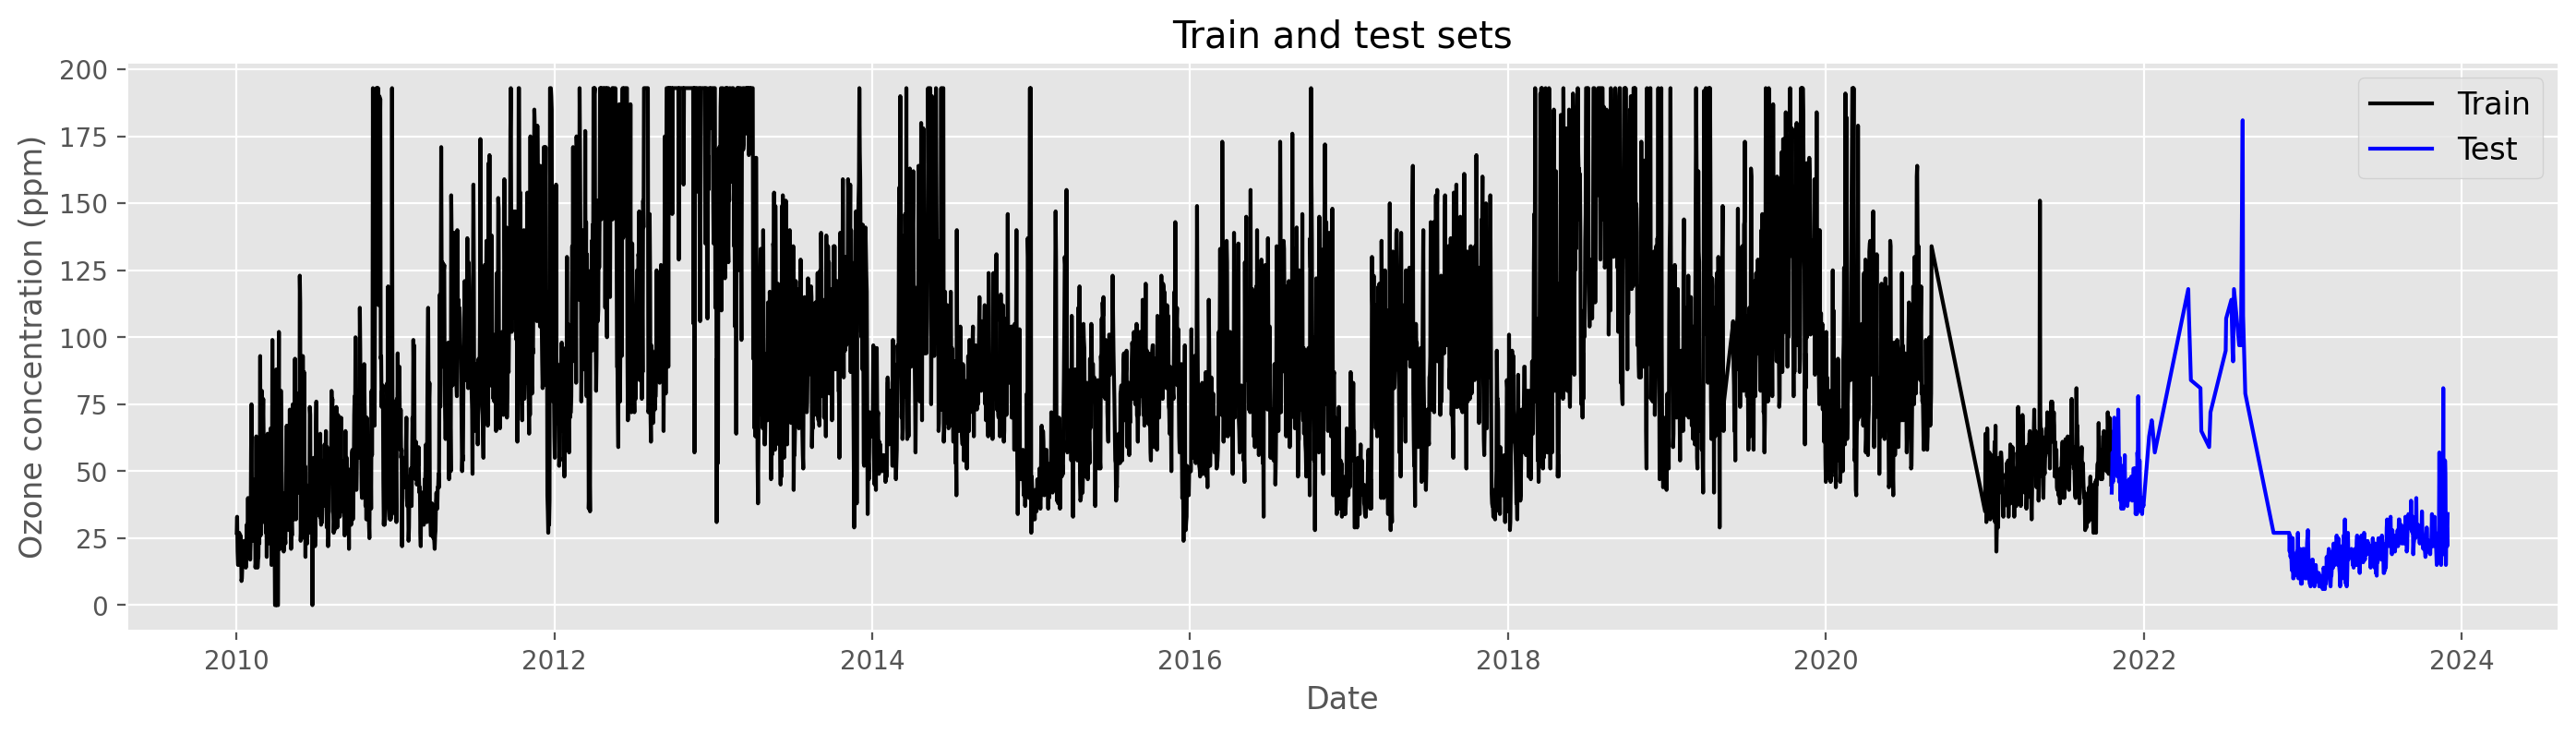

In [633]:
# visualize train and test set
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(train_df['ds'], train_df['y'], color='black', label='Train')
plt.plot(test_df['ds'], test_df['y'], color='blue', label='Test')
plt.xlabel('Date')
plt.ylabel('Ozone concentration (ppm)')
plt.title('Train and test sets')
plt.xticks(rotation=0, ha='center')
plt.legend(fontsize=12)
plt.show()

In [634]:
# train prophet model
prophet_model = Prophet(interval_width=0.95)
prophet_model.fit(train_df)

12:15:17 - cmdstanpy - INFO - Chain [1] start processing
12:15:18 - cmdstanpy - INFO - Chain [1] done processing


In [635]:
# make predictions
forecast_df = prophet_model.predict(test_df[['ds']])
forecast_df.loc[:6, ['ds', 'trend', 'yhat_upper', 'yhat_lower', 'yhat']].round(2)

ds  trend  yhat_upper  yhat_lower   yhat
0 2021-10-19  47.36      123.39       -3.83  61.41
1 2021-10-20  47.29      131.41       -0.56  63.79
2 2021-10-21  47.21      124.25        0.55  61.89
3 2021-10-22  47.14      122.95       -0.73  60.95
4 2021-10-23  47.07      120.69       -4.90  60.38
5 2021-10-24  47.00      120.87       -7.52  57.65
6 2021-10-25  46.93      120.30       -6.98  59.24

In [636]:
# combine actual and predicted values
prophet_predictions = (pd.merge(test_df, 
                                forecast_df.loc[:, ['ds', 'trend', 'yhat_upper', 'yhat_lower', 'yhat']], 
                                on='ds').round(2))

# rearrange columns
prophet_predictions = prophet_predictions.loc[:, ['ds', 'trend', 'y', 'yhat', 'yhat_lower', 'yhat_upper']]
prophet_predictions.head()

ds  trend     y   yhat  yhat_lower  yhat_upper
0 2021-10-19  47.36  42.0  61.41       -3.83      123.39
1 2021-10-20  47.29  50.0  63.79       -0.56      131.41
2 2021-10-21  47.21  57.0  61.89        0.55      124.25
3 2021-10-22  47.14  46.0  60.95       -0.73      122.95
4 2021-10-23  47.07  53.0  60.38       -4.90      120.69

In [637]:
# compute RMSE
rmse_prophet = np.sqrt(mean_squared_error(test_df['y'], forecast_df['yhat']))
print(f'RMSE of Prophet model: {rmse_prophet:.2f}')

RMSE of Prophet model: 23.53


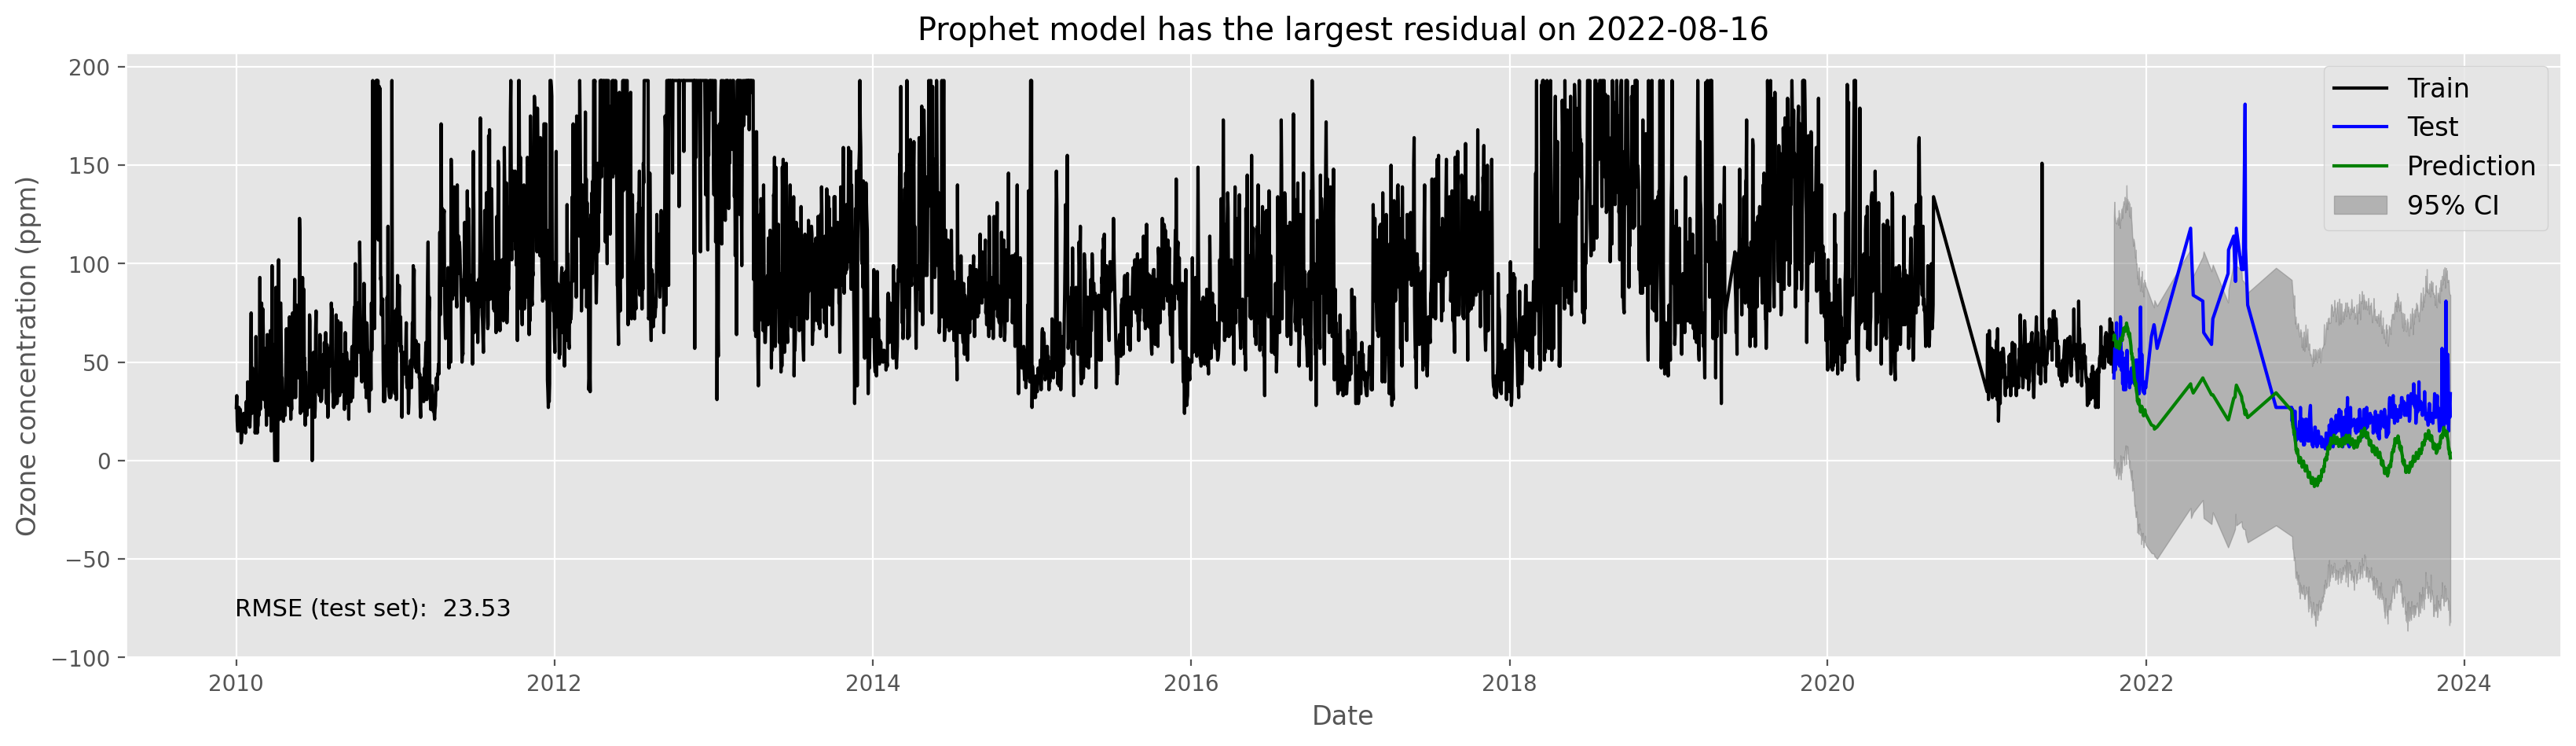

In [638]:
plt.figure(figsize=(20, 5), dpi=200)
plt.plot(train_df['ds'], train_df['y'], color='black', label='Train')
plt.plot(test_df['ds'], test_df['y'], color='blue', label='Test')
plt.plot(forecast_df['ds'], forecast_df['yhat'], color='green', label='Prediction')
plt.fill_between(forecast_df['ds'], forecast_df['yhat_lower'], forecast_df['yhat_upper'], 
                 color='grey', alpha=0.5, label='95% CI')
plt.text(x=0.045, y=0.1, s=f"RMSE (test set):  {rmse_prophet:.2f}", transform=plt.gca().transAxes,
         fontsize=11, verticalalignment='top', horizontalalignment='left', color='black')
plt.xlabel('Date', size=12)
plt.ylabel('Ozone concentration (ppm)')
plt.title('Prophet model has the largest residual on 2022-08-16')
plt.legend(fontsize=12)
plt.show()

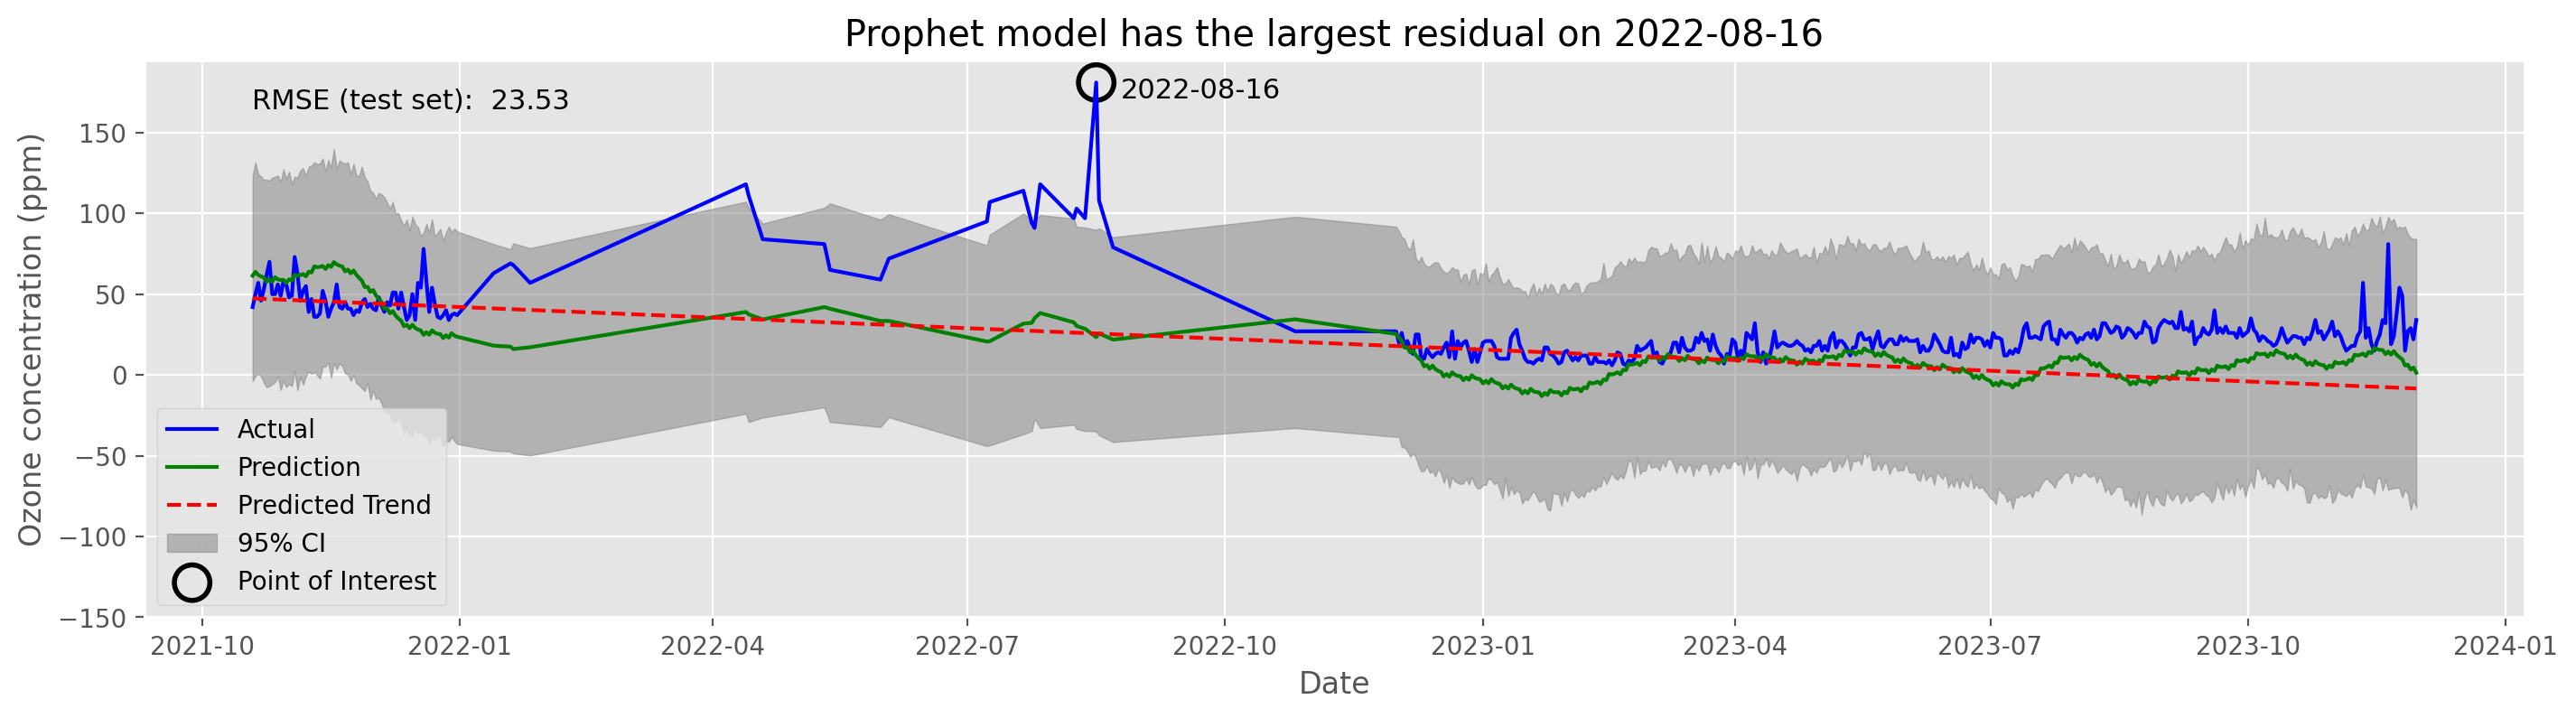

In [639]:
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(test_df['ds'], test_df['y'], color='blue', label='Actual')
plt.plot(forecast_df['ds'], forecast_df['yhat'], color='green', label='Prediction')
plt.plot(forecast_df['ds'], forecast_df['trend'], color='red', label='Predicted Trend', linestyle='--')
plt.fill_between(forecast_df['ds'], forecast_df['yhat_lower'], 
                 forecast_df['yhat_upper'], color='grey', alpha=0.5, label='95% CI')

# Add text
plt.text(x=0.045, y=0.95, s=f"RMSE (test set):  {rmse_prophet:.2f}", transform=plt.gca().transAxes,
         fontsize=11, verticalalignment='top', horizontalalignment='left', color='black')

# Add circle (scatter point) at specific x (date) and y coordinates
plt.scatter(pd.to_datetime('2022-08-16'), 181.0,
            color='red', s=200, facecolors='none', edgecolors='black', linewidths=2, label='Point of Interest')
plt.text(x=0.41, y=0.97, s='2022-08-16', transform=plt.gca().transAxes,
         fontsize=11, verticalalignment='top', horizontalalignment='left', color='black')
plt.xlabel('Date')
plt.ylabel('Ozone concentration (ppm)')
plt.title('Prophet model has the largest residual on 2022-08-16')
plt.yticks(range(-150, 200, 50))
plt.legend()
plt.show()

In [640]:
# locate 2022-08-16
prophet_predictions[prophet_predictions['ds'] == '2022-08-16']

ds  trend      y   yhat  yhat_lower  yhat_upper
94 2022-08-16  25.62  181.0  23.41      -34.93        89.7

In [641]:
# create plots
fig_components = plot_components_plotly(prophet_model, forecast_df)

fig_components.update_layout(
    autosize=False,
    width=1200, 
    height=600,  
    title_text='Component Plots',  
    title_x=0.5,  
    title_font=dict(size=18, family='Arial'), 
    margin=dict(t=50)
)

# Show plots
fig_components.show()

### **3.4 Build LSTM Model**

In [643]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['o3'].values.reshape(-1, 1))

In [644]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df['o3'].values.reshape(-1, 1))

# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i+seq_length]
        target = data[i+seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

sequence_length = 30
X, y = create_sequences(scaled_data, sequence_length)

In [645]:
# Split the data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [646]:
# Define the LSTM model with additional layers and dropout
def create_lstm_model():
    model = Sequential([
        LSTM(100, activation='relu', return_sequences=True, kernel_regularizer=regularizers.l2(0.01),
             input_shape=(sequence_length, 1)),
        Dropout(0.2),
        LSTM(50, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        Dense(1, kernel_regularizer=regularizers.l2(0.01))
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [647]:
# Create and train the LSTM model
lstm_model = create_lstm_model()

# Define early stopping and learning rate scheduler
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = LearningRateScheduler(lambda epoch, lr: lr * 0.9 if epoch > 10 else lr)

history = lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=0,
                         callbacks=[early_stopping, lr_scheduler])

In [648]:
# Evaluate and plot
predictions = lstm_model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test)
rmse = np.sqrt(mean_squared_error(y_test_inv, predictions))

print(f"LSTM Model RMSE: {rmse:.2f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
LSTM Model RMSE: 25.98


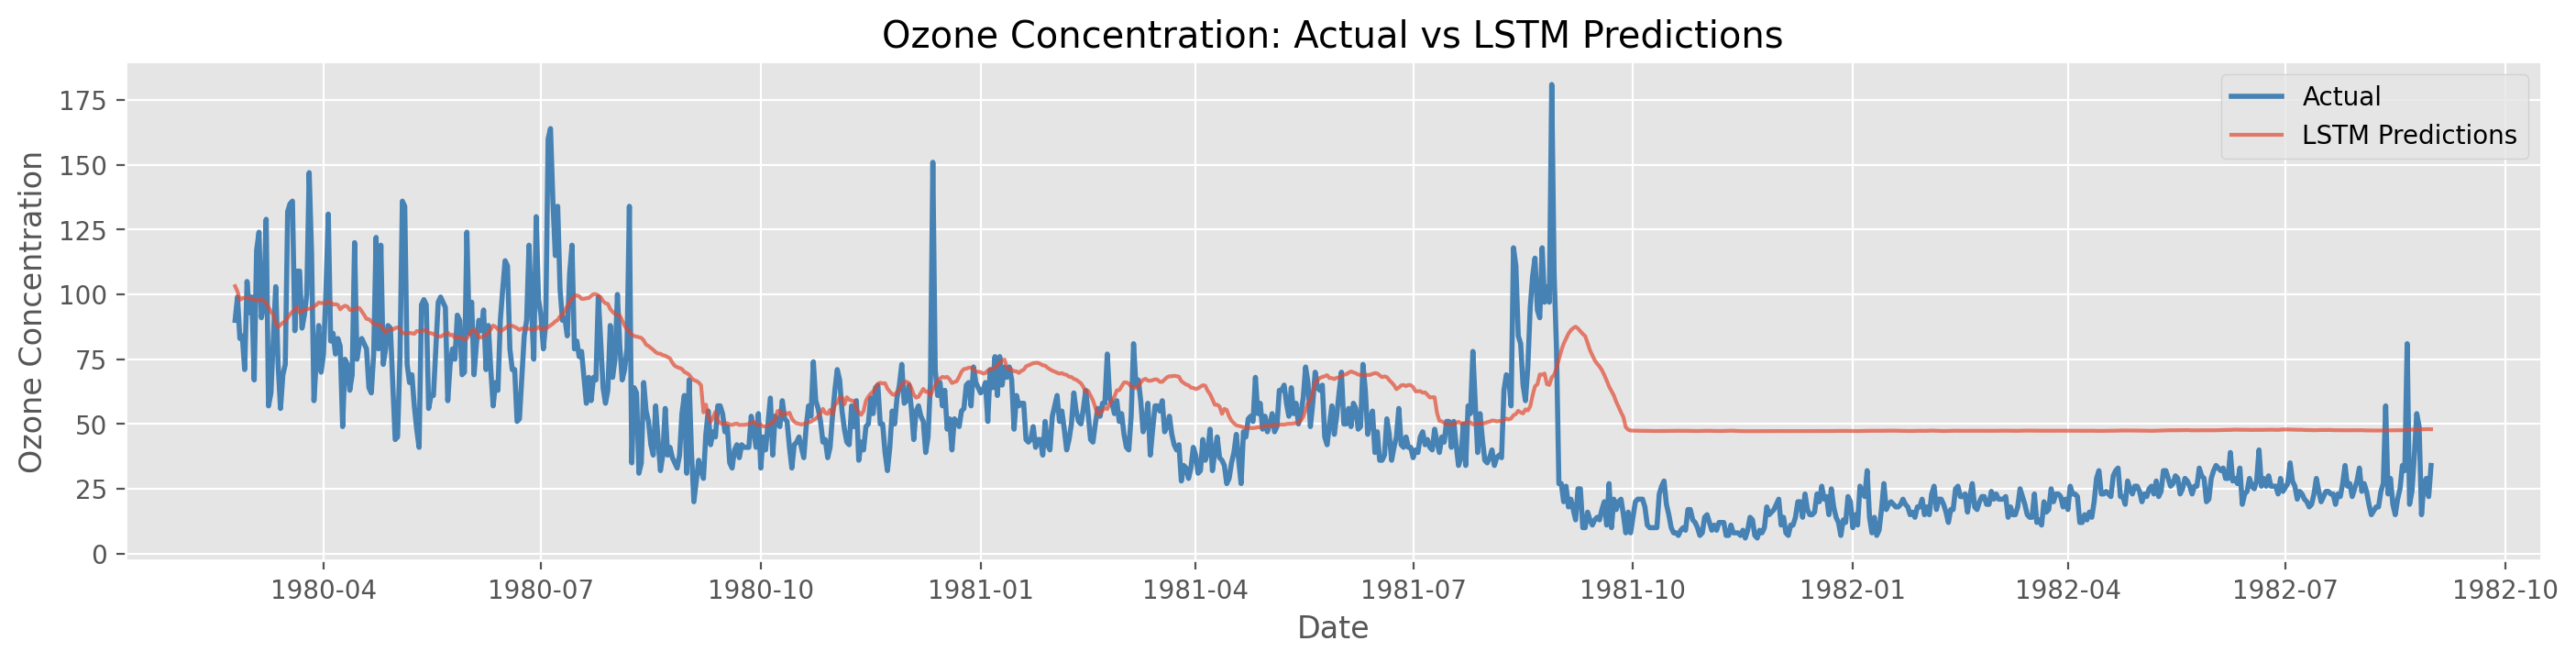

In [649]:
# Plot results
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(df.index[-len(y_test):], scaler.inverse_transform(y_test), 
         label='Actual', linewidth=2, color='steelblue')
plt.plot(df.index[-len(y_test):], predictions, 
         label='LSTM Predictions', alpha=0.7)
plt.title('Ozone Concentration: Actual vs LSTM Predictions')
plt.xlabel('Date')
plt.ylabel('Ozone Concentration')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()
plt.xticks(rotation=0, ha='center')
plt.legend()
plt.show()

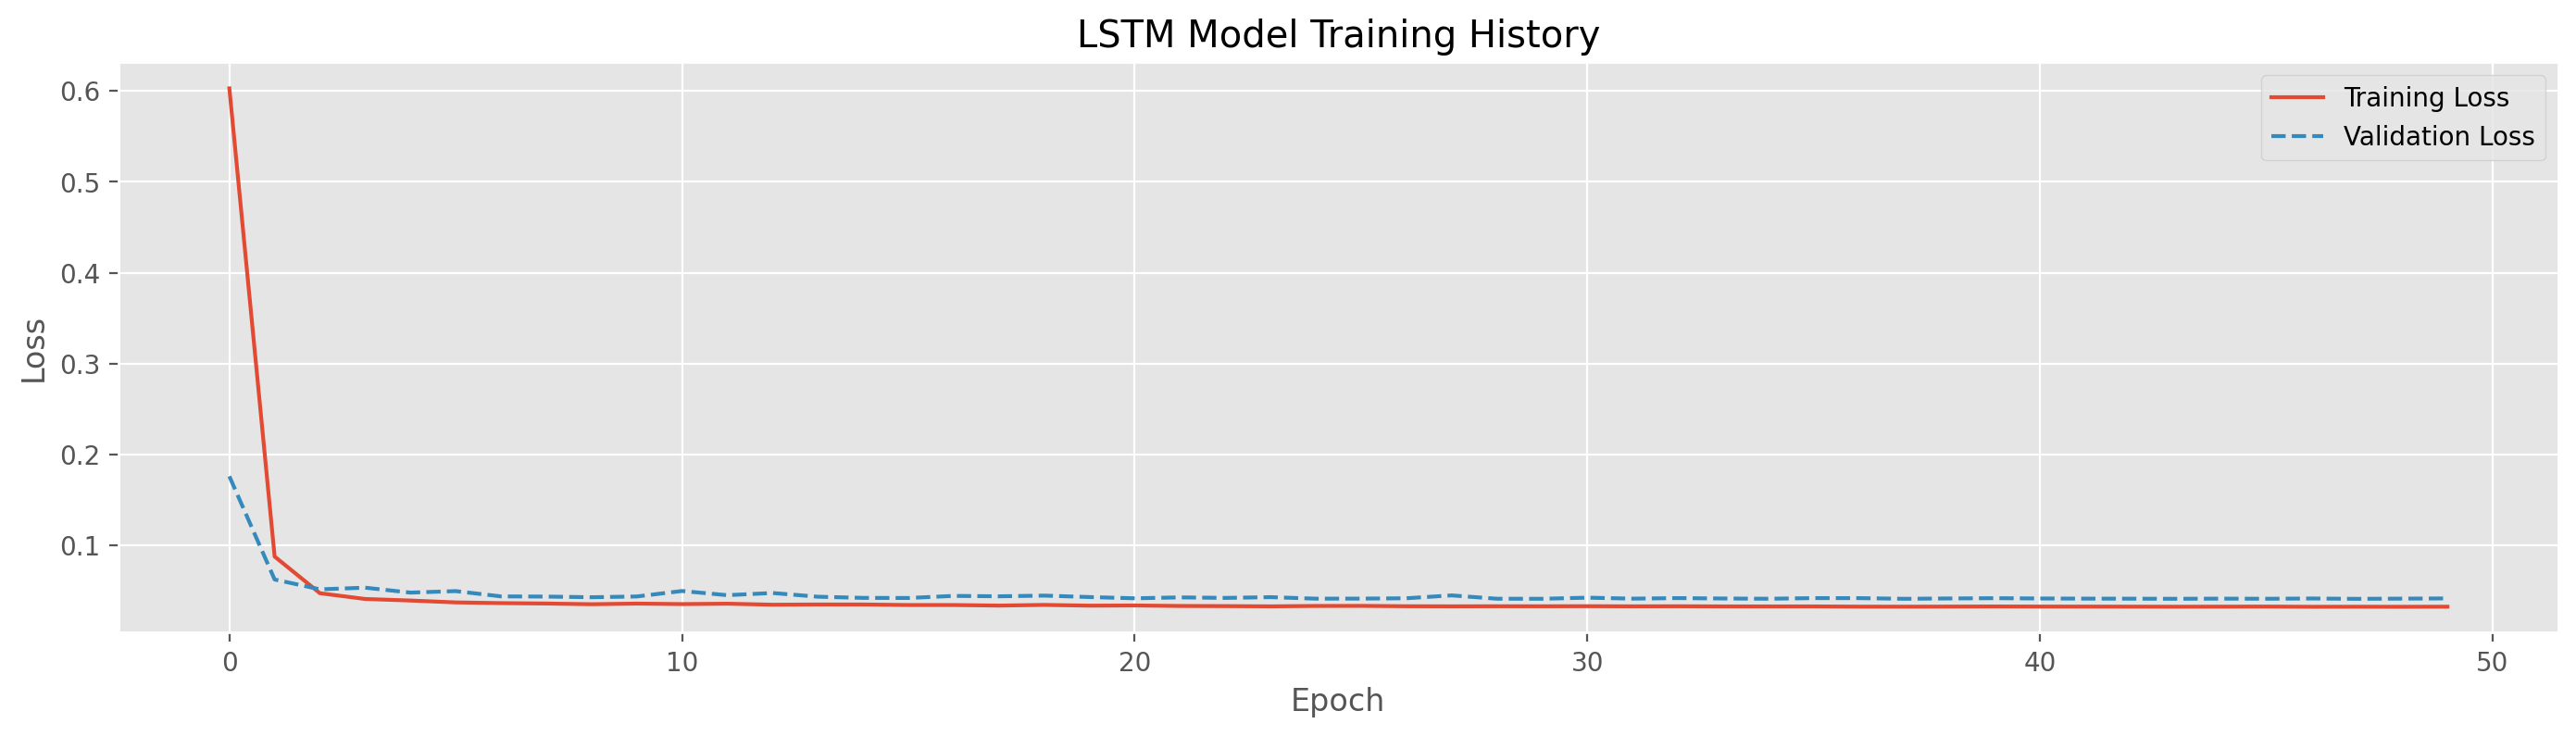

In [650]:
# Plot training history
plt.figure(figsize=(17, 4), dpi=200)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('LSTM Model Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Based on the “LSTM Model Training History” graph you provided, the model does not appear to be underfitting. Here are the key observations:

Training and Validation Loss: Both the training and validation losses decrease sharply initially and then level off, closely following each other throughout the epochs.
Convergence: The close alignment of training and validation losses at a low level indicates that the model is learning effectively and generalizing well to the validation data.
Underfitting would typically be indicated by high training loss or a significant gap between training and validation losses. Since neither of these is present, the model is not underfitting.

## **4 Conclusions**
<span style='color:red'>Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum.</span>

<h1 style='text-align:center; font-weight:bold; color:orange'>--END--</h1>